In [1]:
%pylab inline

from __future__ import (division, print_function)

import os
import sys
import copy
import fnmatch
import warnings
import collections

import numpy as np
import scipy

import angles

try:
    from scipy.stats import scoreatpercentile
except:
    scoreatpercentile = False
from scipy.stats import norm
from scipy.interpolate import interp1d
import cPickle as pickle

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar

# AstroML
from astroML.plotting import hist

# Matplotlib related
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator

# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 2.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 2.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 2.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 2.5

# ColorMap
from palettable.colorbrewer.sequential import Greys_7, Blues_8, Greens_6, Oranges_6
cmap0 = Greys_7.mpl_colormap
cmap1 = Blues_8.mpl_colormap
cmap2 = Greens_6.mpl_colormap
cmap3 = Oranges_6.mpl_colormap

# Cubehelix color scheme from https://github.com/jradavenport/cubehelix
import cubehelix  
cmap4 = cubehelix.cmap(start=0.5, rot=-0.8, gamma=1.0, 
                       minSat=1.2, maxSat=1.2, 
                       minLight=0.0, maxLight=1.0)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Error for aperture correction: 
# 1: cmodel.flux.apcorr / cmodel.flux.apcorr.err 
# 2: cmodel.dev.flux.apcorr / cmodel.dev.flux.apcorr.err 
# 3: cmodel.exp.flux.apcorr / cmodel.exp.flux.apcorr.err 
# 4: flux.kron.apcorr / flux.kron.apcorr.err 
# Also there are errors for magnitude 

def beforeApCor(cat, fluxStr): 
    """
    Get the flux and its error before the aperture correction.

    """
    fluxAfter = cat[fluxStr]
    fluxErrAfter = cat [fluxStr + '.err']

    apCor = cat[fluxStr + '.apcorr']
    apCorErr= cat[fluxStr + '.apcorr.err']
    
    fluxBefore = (fluxAfter / apCor)
    fluxErrBefore = (fluxAfter / apCor) * sqrt((fluxErrAfter / fluxAfter)**2.0 
                                               - (apCorErr / apCor)**2.0)
    
    return fluxBefore, fluxErrBefore

def mag2Flux(mag, zp=27.0): 
    """
    mag = -2.5 * np.log10(flux) + zp 
    """
    flux = 10.0 ** ((zp - mag) / 2.5)
    
    return flux 

def s2nFromMag(cat, magStr): 
    """
    Estimate S/N from magnitude 
    """
    
    magAfter = cat[magStr]
    magErrAfter = cat[magStr + '.err']
    
    apCor = cat[magStr + '.apcorr']
    apCorErr = cat[magStr + '.apcorr.err']
    
    s2nAfter = mag2Flux(magAfter) / (mag2Flux(magAfter) - mag2Flux(magAfter + magErrAfter))
    
    return s2nAfter

In [3]:
# Code for Get Bootstrap mean or median 
def _confidence_interval_1d(A, alpha=.05, metric=np.mean, numResamples=10000, interpolate=True):
    """Calculates bootstrap confidence interval along one dimensional array"""
    
    if not isinstance(alpha, collections.Iterable):
        alpha = np.array([alpha])

    N = len(A)
    resampleInds = np.random.randint(0, N, (numResamples,N))
    metricOfResampled = metric(A[resampleInds], axis=-1)

    confidenceInterval = np.zeros(2*len(alpha),dtype='float')
    
    if interpolate:
        for thisAlphaInd, thisAlpha in enumerate(alpha):
            confidenceInterval[2*thisAlphaInd] = scoreatpercentile(metricOfResampled, 
                                                                   thisAlpha*100/2.0)
            confidenceInterval[2*thisAlphaInd+1] = scoreatpercentile(metricOfResampled, 
                                                                     100-thisAlpha*100/2.0)
    else:
        sortedMetricOfResampled = np.sort(metricOfResampled)
        for thisAlphaInd, thisAlpha in enumerate(alpha):
            confidenceInterval[2*thisAlphaInd] = sortedMetricOfResampled[int(round(thisAlpha*numResamples/2.0))]
            confidenceInterval[2*thisAlphaInd+1] = sortedMetricOfResampled[int(round(numResamples - 
                                                                                     thisAlpha*numResamples/2.0))]
    return confidenceInterval
    
def _ma_confidence_interval_1d(A, alpha=.05, metric=np.mean, numResamples=10000, interpolate=True):
    A = np.ma.masked_invalid(A, copy=True)
    A = A.compressed()
    confidenceInterval = _confidence_interval_1d(A, alpha, metric, numResamples, interpolate)
    return confidenceInterval

def confidence_interval(A, axis=None, alpha=.05, metric=np.mean, numResamples=10000, interpolate=True):
    """Return the bootstrap confidence interval of an array or along an axis ignoring NaNs and masked elements.
    
    Parameters
    ----------
    A : array_like
        Array containing numbers whose confidence interval is desired. 
    axis : int, optional
        Axis along which the confidence interval is computed.
        The default is to compute the confidence interval of the flattened array.
    alpha: float or array, optional
        confidence level of confidence interval. 100.0*(1-alpha) percent confidence 
        interval will be returned.
        If length-n array, n confidence intervals will be computed
        The default is .05
    metric : numpy function, optional
        metric to calculate confidence interval for.
        The default is numpy.mean
    numResamples : int, optional
        number of bootstrap samples. The default is 10000.
    interpolate: bool, optional
        uses scipy.stats.scoreatpercentile to interpolate between bootstrap samples 
        if alpha*numResamples/2.0 is not integer.
        The default is True
        
    Returns
    -------
    confidenceInterval : ndarray
    An array with the same shape as `A`, with the specified axis replaced by one twice the length of the alpha
    If `A` is a 0-d array, or if axis is None, a length-2 ndarray is returned.
    """
    if interpolate is True and scoreatpercentile is False:
        print("need scipy to interpolate between values")
        interpolate = False
    A = A.copy()
    if axis is None:
        A = A.ravel()
        outA = _ma_confidence_interval_1d(A, alpha, metric, numResamples, interpolate)
    else:
        outA = np.apply_along_axis(_ma_confidence_interval_1d, axis, A, alpha, 
                                   metric, numResamples, interpolate)
        
    return outA

In [4]:
### Fancy one 

# definitions for the axes
left, width    = 0.1, 0.71
right          = left + width 
bottom, height = 0.1, 0.88
bottom_h = left_h = left + width + 0.02
recScat = [left,   bottom, width, height]
recHist = [right,  bottom,  0.18, height]

# Summary of fakeTest results: 2016-01

In [5]:
loc = '/Users/songhuang/Downloads/match'

# FULL_8766 & FULL_8767
catI1 = 'full_both_I_multiband.fits'
catG1 = 'full_both_G_multiband.fits'
catR1 = 'full_both_R_multiband.fits'

# BRIGHT_8767 
catI2 = 'bright_8767_I_multiband.fits'
catG2 = 'bright_8767_G_multiband.fits'
catR2 = 'bright_8767_R_multiband.fits'

# BLEND_8767 
catI3 = 'blend_8767_I_multiband.fits'
catG3 = 'blend_8767_G_multiband.fits'
catR3 = 'blend_8767_R_multiband.fits'

# TIGHT_8767 
catI4 = 'tight_8767_I_multiband.fits'
catG4 = 'tight_8767_G_multiband.fits'
catR4 = 'tight_8767_R_multiband.fits'

In [6]:
# Read in the data 

dataI1 = Table.read(os.path.join(loc, catI1), format='fits')
dataG1 = Table.read(os.path.join(loc, catG1), format='fits')
dataR1 = Table.read(os.path.join(loc, catR1), format='fits')

dataI2 = Table.read(os.path.join(loc, catI2), format='fits')
dataG2 = Table.read(os.path.join(loc, catG2), format='fits')
dataR2 = Table.read(os.path.join(loc, catR2), format='fits')

dataI3 = Table.read(os.path.join(loc, catI3), format='fits')
dataG3 = Table.read(os.path.join(loc, catG3), format='fits')
dataR3 = Table.read(os.path.join(loc, catR3), format='fits')

dataI4 = Table.read(os.path.join(loc, catI4), format='fits')
dataG4 = Table.read(os.path.join(loc, catG4), format='fits')
dataR4 = Table.read(os.path.join(loc, catR4), format='fits')

## Basic statistics of the sample 

### FULL_8766 / 8767

In [79]:
print("## Full_8766/8767 Sample: HSC-I\n")
print("##   %d Fake Objects" % len(dataI1))

## Very basic cut: Matched, Not parent, Is-Primary
matchI1 = dataI1[(dataI1['id'] > 0) & (dataI1['deblend.nchild'] == 0) & 
                 (dataI1['detect.is-patch-inner'])] 
print("##   %d Inner-Patch, non-parent matches" % len(matchI1))

## Photometry cuts: 
print("##    %f %% has no cModel Magnitude" % (100.0 * (1.0 - len(matchI1[np.isfinite(matchI1['cmodel.mag'])]) / 
                                                        len(matchI1))))
print("##    %f %% has no Kron Magnitude" % (100.0 * (1.0 - len(matchI1[np.isfinite(matchI1['mag.kron'])]) / 
                                                      len(matchI1))))
print("##    %f %% has no PSF Magnitude" % (100.0 * (1.0 - len(matchI1[np.isfinite(matchI1['mag.psf'])]) / 
                                                      len(matchI1))))
print("##    %f %% is classified as star" % (100.0 * (len(matchI1[matchI1['classification.extendedness'] < 0.5]) / 
                                                      len(matchI1))))

## Photometric sample 
photoI1 = matchI1[(np.isfinite(matchI1['cmodel.mag'])) & 
                  (np.isfinite(matchI1['mag.kron'])) & 
                  (np.isfinite(matchI1['mag.psf'])) & 
                  (matchI1['classification.extendedness'] > 0.5) & 
                  (~matchI1['flags.pixel.clipped.any']) & 
                  (~matchI1['flags.pixel.interpolated.any']) & 
                  (~matchI1['flags.pixel.saturated.any']) &
                  (~matchI1['flags.pixel.edge']) &
                  (~matchI1['flags.pixel.suspect.any']) &
                  (~matchI1['flags.badcentroid'])]
print("##    %d survive the photometric cut" % len(photoI1))

## Non-blended cut
isolateI1 = photoI1[(photoI1['parent'] == 0) &
                    (~photoI1['flags.pixel.bright.object.any'])]
print("##    %d are relative isolated" % len(isolateI1))

## Close to bright star
nearStarI1 = photoI1[photoI1['flags.pixel.bright.object.any']]
print("##    %d are close to bright star" % len(nearStarI1))

## Highly Blended Ones
blendedI1 = photoI1[photoI1['blendedness.abs.flux'] >= 0.15]
print("##    %d are highly blended" % len(blendedI1))

## Full_8766/8767 Sample: HSC-I

##   103090 Fake Objects
##   68214 Inner-Patch, non-parent matches
##    0.606914 % has no cModel Magnitude
##    3.858445 % has no Kron Magnitude
##    0.026388 % has no PSF Magnitude
##    3.704518 % is classified as star
##    59766 survive the photometric cut
##    14851 are relative isolated
##    8531 are close to bright star
##    2616 are highly blended


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in greater_equal


In [81]:
print("## Full_8766/8767 Sample: HSC-G\n")
print("##   %d Fake Objects" % len(dataG1))

## Very basic cut: Matched, Not parent, Is-Primary
matchG1 = dataG1[(dataG1['id'] > 0) & (dataG1['deblend.nchild'] == 0) & 
                 (dataG1['detect.is-patch-inner'])] 
print("##   %d Inner-Patch, non-parent matches" % len(matchG1))

## Photometry cuts: 
print("##    %f %% has no cModel Magnitude" % (100.0 * (1.0 - len(matchG1[np.isfinite(matchG1['cmodel.mag'])]) / 
                                                        len(matchG1))))
print("##    %f %% has no Kron Magnitude" % (100.0 * (1.0 - len(matchG1[np.isfinite(matchG1['mag.kron'])]) / 
                                                      len(matchG1))))
print("##    %f %% has no PSF Magnitude" % (100.0 * (1.0 - len(matchG1[np.isfinite(matchG1['mag.psf'])]) / 
                                                      len(matchG1))))
print("##    %f %% is classified as star" % (100.0 * (len(matchG1[matchG1['classification.extendedness'] < 0.5]) / 
                                                      len(matchG1))))

## Photometric sample 
photoG1 = matchG1[(np.isfinite(matchG1['cmodel.mag'])) & 
                  (np.isfinite(matchG1['mag.kron'])) & 
                  (np.isfinite(matchG1['mag.psf'])) & 
                  (matchG1['classification.extendedness'] > 0.5) & 
                  (~matchG1['flags.pixel.clipped.any']) & 
                  (~matchG1['flags.pixel.interpolated.any']) & 
                  (~matchG1['flags.pixel.saturated.any']) &
                  (~matchG1['flags.pixel.edge']) &
                  (~matchG1['flags.pixel.suspect.any']) &
                  (~matchG1['flags.badcentroid'])]
print("##    %d survive the photometric cut" % len(photoG1))

## Non-blended cut
isolateG1 = photoG1[(photoG1['parent'] == 0) &
                    (~photoG1['flags.pixel.bright.object.any'])]
print("##    %d are relative isolated" % len(isolateG1))

## Close to bright star
nearStarG1 = photoG1[photoG1['flags.pixel.bright.object.any']]
print("##    %d are close to bright star" % len(nearStarG1))

## Highly Blended Ones
blendedG1 = photoG1[photoG1['blendedness.abs.flux'] >= 0.15]
print("##    %d are highly blended" % len(blendedG1))

## Full_8766/8767 Sample: HSC-G

##   91418 Fake Objects
##   34713 Inner-Patch, non-parent matches
##    0.426353 % has no cModel Magnitude
##    3.549103 % has no Kron Magnitude
##    0.037450 % has no PSF Magnitude
##    6.444272 % is classified as star
##    30195 survive the photometric cut
##    6308 are relative isolated
##    6936 are close to bright star
##    1669 are highly blended


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in greater_equal


In [82]:
print("## Full_8766/8767 Sample: HSC-R\n")
print("##   %d Fake Objects" % len(dataR1))

## Very basic cut: Matched, Not parent, Is-Primary
matchR1 = dataR1[(dataR1['id'] > 0) & (dataR1['deblend.nchild'] == 0) & 
                 (dataR1['detect.is-patch-inner'])] 
print("##   %d Inner-Patch, non-parent matches" % len(matchR1))

## Photometry cuts: 
print("##    %f %% has no cModel Magnitude" % (100.0 * (1.0 - len(matchR1[np.isfinite(matchR1['cmodel.mag'])]) / 
                                                        len(matchR1))))
print("##    %f %% has no Kron Magnitude" % (100.0 * (1.0 - len(matchR1[np.isfinite(matchR1['mag.kron'])]) / 
                                                      len(matchR1))))
print("##    %f %% has no PSF Magnitude" % (100.0 * (1.0 - len(matchR1[np.isfinite(matchR1['mag.psf'])]) / 
                                                      len(matchR1))))
print("##    %f %% is classified as star" % (100.0 * (len(matchR1[matchR1['classification.extendedness'] < 0.5]) / 
                                                      len(matchR1))))

## Photometric sample 
photoR1 = matchR1[(np.isfinite(matchR1['cmodel.mag'])) & 
                  (np.isfinite(matchR1['mag.kron'])) & 
                  (np.isfinite(matchR1['mag.psf'])) & 
                  (matchR1['classification.extendedness'] > 0.5) & 
                  (~matchR1['flags.pixel.clipped.any']) & 
                  (~matchR1['flags.pixel.interpolated.any']) & 
                  (~matchR1['flags.pixel.saturated.any']) &
                  (~matchR1['flags.pixel.edge']) &
                  (~matchR1['flags.pixel.suspect.any']) &
                  (~matchR1['flags.badcentroid'])]
print("##    %d survive the photometric cut" % len(photoR1))

## Non-blended cut
isolateR1 = photoR1[(photoR1['parent'] == 0) &
                    (~photoR1['flags.pixel.bright.object.any'])]
print("##    %d are relative isolated" % len(isolateR1))

## Close to bright star
nearStarR1 = photoR1[photoR1['flags.pixel.bright.object.any']]
print("##    %d are close to bright star" % len(nearStarR1))

## Highly Blended Ones
blendedR1 = photoR1[photoR1['blendedness.abs.flux'] >= 0.15]
print("##    %d are highly blended" % len(blendedR1))

## Full_8766/8767 Sample: HSC-R

##   102990 Fake Objects
##   68127 Inner-Patch, non-parent matches
##    0.430079 % has no cModel Magnitude
##    4.349230 % has no Kron Magnitude
##    0.017614 % has no PSF Magnitude
##    7.814816 % is classified as star
##    57651 survive the photometric cut
##    13924 are relative isolated
##    8911 are close to bright star
##    3182 are highly blended


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in greater_equal


### BRIGHT_8767

In [84]:
print("## BRIGHT_8767 Sample: HSC-I\n")
print("##   %d Fake Objects" % len(dataI2))

## Very basic cut: Matched, Not parent, Is-Primary
matchI2 = dataI2[(dataI2['id'] > 0) & (dataI2['deblend.nchild'] == 0) & 
                 (dataI2['detect.is-patch-inner'])] 
print("##   %d Inner-Patch, non-parent matches" % len(matchI2))

## Photometry cuts: 
print("##    %f %% has no cModel Magnitude" % (100.0 * (1.0 - len(matchI2[np.isfinite(matchI2['cmodel.mag'])]) / 
                                                        len(matchI2))))
print("##    %f %% has no Kron Magnitude" % (100.0 * (1.0 - len(matchI2[np.isfinite(matchI2['mag.kron'])]) / 
                                                      len(matchI2))))
print("##    %f %% has no PSF Magnitude" % (100.0 * (1.0 - len(matchI2[np.isfinite(matchI2['mag.psf'])]) / 
                                                      len(matchI2))))
print("##    %f %% is classified as star" % (100.0 * (len(matchI2[matchI2['classification.extendedness'] < 0.5]) / 
                                                      len(matchI2))))

## Photometric sample 
photoI2 = matchI2[(np.isfinite(matchI2['cmodel.mag'])) & 
                  (np.isfinite(matchI2['mag.kron'])) & 
                  (np.isfinite(matchI2['mag.psf'])) & 
                  (matchI2['classification.extendedness'] > 0.5) & 
                  (~matchI2['flags.pixel.clipped.any']) & 
                  (~matchI2['flags.pixel.interpolated.any']) & 
                  (~matchI2['flags.pixel.saturated.any']) &
                  (~matchI2['flags.pixel.edge']) &
                  (~matchI2['flags.pixel.suspect.any']) &
                  (~matchI2['flags.badcentroid'])]
print("##    %d survive the photometric cut" % len(photoI2))

## Non-blended cut
isolateI2 = photoI2[(photoI2['parent'] == 0) &
                    (~photoI2['flags.pixel.bright.object.any'])]
print("##    %d are relative isolated" % len(isolateI2))

## Close to bright star
nearStarI2 = photoI2[photoI2['flags.pixel.bright.object.any']]
print("##    %d are close to bright star" % len(nearStarI2))

## Highly Blended Ones
blendedI2 = photoI2[photoI2['blendedness.abs.flux'] >= 0.15]
print("##    %d are highly blended" % len(blendedI2))

## BRIGHT_8767 Sample: HSC-I

##   43226 Fake Objects
##   23910 Inner-Patch, non-parent matches
##    0.819741 % has no cModel Magnitude
##    0.025094 % has no Kron Magnitude
##    0.008365 % has no PSF Magnitude
##    0.004182 % is classified as star
##    22144 survive the photometric cut
##    1749 are relative isolated
##    1633 are close to bright star
##    358 are highly blended


In [85]:
print("## BRIGHT_8767 Sample: HSC-G\n")
print("##   %d Fake Objects" % len(dataG2))

## Very basic cut: Matched, Not parent, Is-Primary
matchG2 = dataG2[(dataG2['id'] > 0) & (dataG2['deblend.nchild'] == 0) & 
                 (dataG2['detect.is-patch-inner'])] 
print("##   %d Inner-Patch, non-parent matches" % len(matchG2))

## Photometry cuts: 
print("##    %f %% has no cModel Magnitude" % (100.0 * (1.0 - len(matchG2[np.isfinite(matchG2['cmodel.mag'])]) / 
                                                        len(matchG2))))
print("##    %f %% has no Kron Magnitude" % (100.0 * (1.0 - len(matchG2[np.isfinite(matchG2['mag.kron'])]) / 
                                                      len(matchG2))))
print("##    %f %% has no PSF Magnitude" % (100.0 * (1.0 - len(matchG2[np.isfinite(matchG2['mag.psf'])]) / 
                                                      len(matchG2))))
print("##    %f %% is classified as star" % (100.0 * (len(matchG2[matchG2['classification.extendedness'] < 0.5]) / 
                                                      len(matchG2))))

## Photometric sample 
photoG2 = matchG2[(np.isfinite(matchG2['cmodel.mag'])) & 
                  (np.isfinite(matchG2['mag.kron'])) & 
                  (np.isfinite(matchG2['mag.psf'])) & 
                  (matchG2['classification.extendedness'] > 0.5) & 
                  (~matchG2['flags.pixel.clipped.any']) & 
                  (~matchG2['flags.pixel.interpolated.any']) & 
                  (~matchG2['flags.pixel.saturated.any']) &
                  (~matchG2['flags.pixel.edge']) &
                  (~matchG2['flags.pixel.suspect.any']) &
                  (~matchG2['flags.badcentroid'])]
print("##    %d survive the photometric cut" % len(photoG2))

## Non-blended cut
isolateG2 = photoG2[(photoG2['parent'] == 0) &
                    (~photoG2['flags.pixel.bright.object.any'])]
print("##    %d are relative isolated" % len(isolateG2))

## Close to bright star
nearStarG2 = photoG2[photoG2['flags.pixel.bright.object.any']]
print("##    %d are close to bright star" % len(nearStarG2))

## Highly Blended Ones
blendedG2 = photoG2[photoG2['blendedness.abs.flux'] >= 0.15]
print("##    %d are highly blended" % len(blendedG2))

## BRIGHT_8767 Sample: HSC-G

##   43274 Fake Objects
##   23956 Inner-Patch, non-parent matches
##    0.308900 % has no cModel Magnitude
##    0.045918 % has no Kron Magnitude
##    0.000000 % has no PSF Magnitude
##    0.020872 % is classified as star
##    22530 survive the photometric cut
##    1783 are relative isolated
##    1754 are close to bright star
##    374 are highly blended


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in greater_equal


In [87]:
print("## BRIGHT_8767 Sample: HSC-R\n")
print("##   %d Fake Objects" % len(dataR2))

## Very basic cut: Matched, Not parent, Is-Primary
matchR2 = dataR2[(dataR2['id'] > 0) & (dataR2['deblend.nchild'] == 0) & 
                 (dataR2['detect.is-patch-inner'])] 
print("##   %d Inner-Patch, non-parent matches" % len(matchR2))

## Photometry cuts: 
print("##    %f %% has no cModel Magnitude" % (100.0 * (1.0 - len(matchR2[np.isfinite(matchR2['cmodel.mag'])]) / 
                                                        len(matchR2))))
print("##    %f %% has no Kron Magnitude" % (100.0 * (1.0 - len(matchR2[np.isfinite(matchR2['mag.kron'])]) / 
                                                      len(matchR2))))
print("##    %f %% has no PSF Magnitude" % (100.0 * (1.0 - len(matchR2[np.isfinite(matchR2['mag.psf'])]) / 
                                                      len(matchR2))))
print("##    %f %% is classified as star" % (100.0 * (len(matchR2[matchR2['classification.extendedness'] < 0.5]) / 
                                                      len(matchR2))))

## Photometric sample 
photoR2 = matchR2[(np.isfinite(matchR2['cmodel.mag'])) & 
                  (np.isfinite(matchR2['mag.kron'])) & 
                  (np.isfinite(matchR2['mag.psf'])) & 
                  (matchR2['classification.extendedness'] > 0.5) & 
                  (~matchR2['flags.pixel.clipped.any']) & 
                  (~matchR2['flags.pixel.interpolated.any']) & 
                  (~matchR2['flags.pixel.saturated.any']) &
                  (~matchR2['flags.pixel.edge']) &
                  (~matchR2['flags.pixel.suspect.any']) &
                  (~matchR2['flags.badcentroid'])]
print("##    %d survive the photometric cut" % len(photoR2))

## Non-blended cut
isolateR2 = photoR2[(photoR2['parent'] == 0) &
                    (~photoR2['flags.pixel.bright.object.any'])]
print("##    %d are relative isolated" % len(isolateR2))

## Close to bright star
nearStarR2 = photoR2[photoR2['flags.pixel.bright.object.any']]
print("##    %d are close to bright star" % len(nearStarR2))

## Highly Blended Ones
blendedR2 = photoR2[photoR2['blendedness.abs.flux'] >= 0.15]
print("##    %d are highly blended" % len(blendedR2))

## BRIGHT_8767 Sample: HSC-R

##   43237 Fake Objects
##   23936 Inner-Patch, non-parent matches
##    0.555648 % has no cModel Magnitude
##    0.033422 % has no Kron Magnitude
##    0.000000 % has no PSF Magnitude
##    0.016711 % is classified as star
##    22409 survive the photometric cut
##    1781 are relative isolated
##    1694 are close to bright star
##    458 are highly blended


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in greater_equal


### BLEND_8767

In [88]:
print("## BLEND_8767 Sample: HSC-I\n")
print("##   %d Fake Objects" % len(dataI3))

## Very basic cut: Matched, Not parent, Is-Primary
matchI3 = dataI3[(dataI3['id'] > 0) & (dataI3['deblend.nchild'] == 0) & 
                 (dataI3['detect.is-patch-inner'])] 
print("##   %d Inner-Patch, non-parent matches" % len(matchI3))

## Photometry cuts: 
print("##    %f %% has no cModel Magnitude" % (100.0 * (1.0 - len(matchI3[np.isfinite(matchI3['cmodel.mag'])]) / 
                                                        len(matchI3))))
print("##    %f %% has no Kron Magnitude" % (100.0 * (1.0 - len(matchI3[np.isfinite(matchI3['mag.kron'])]) / 
                                                      len(matchI3))))
print("##    %f %% has no PSF Magnitude" % (100.0 * (1.0 - len(matchI3[np.isfinite(matchI3['mag.psf'])]) / 
                                                      len(matchI3))))
print("##    %f %% is classified as star" % (100.0 * (len(matchI3[matchI3['classification.extendedness'] < 0.5]) / 
                                                      len(matchI3))))

## Photometric sample 
photoI3 = matchI3[(np.isfinite(matchI3['cmodel.mag'])) & 
                  (np.isfinite(matchI3['mag.kron'])) & 
                  (np.isfinite(matchI3['mag.psf'])) & 
                  (matchI3['classification.extendedness'] > 0.5) & 
                  (~matchI3['flags.pixel.clipped.any']) & 
                  (~matchI3['flags.pixel.interpolated.any']) & 
                  (~matchI3['flags.pixel.saturated.any']) &
                  (~matchI3['flags.pixel.edge']) &
                  (~matchI3['flags.pixel.suspect.any']) &
                  (~matchI3['flags.badcentroid'])]
print("##    %d survive the photometric cut" % len(photoI3))

## Non-blended cut
isolateI3 = photoI3[(photoI3['parent'] == 0) &
                    (~photoI3['flags.pixel.bright.object.any'])]
print("##    %d are relative isolated" % len(isolateI3))

## Close to bright star
nearStarI3 = photoI3[photoI3['flags.pixel.bright.object.any']]
print("##    %d are close to bright star" % len(nearStarI3))

## Highly Blended Ones
blendedI3 = photoI3[photoI3['blendedness.abs.flux'] >= 0.15]
print("##    %d are highly blended" % len(blendedI3))

## BLEND_8767 Sample: HSC-I

##   45766 Fake Objects
##   27843 Inner-Patch, non-parent matches
##    0.434580 % has no cModel Magnitude
##    1.547965 % has no Kron Magnitude
##    0.000000 % has no PSF Magnitude
##    2.937902 % is classified as star
##    25934 survive the photometric cut
##    700 are relative isolated
##    1698 are close to bright star
##    4732 are highly blended


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in greater_equal


In [89]:
print("## BLEND_8767 Sample: HSC-G\n")
print("##   %d Fake Objects" % len(dataG3))

## Very basic cut: Matched, Not parent, Is-Primary
matchG3 = dataG3[(dataG3['id'] > 0) & (dataG3['deblend.nchild'] == 0) & 
                 (dataG3['detect.is-patch-inner'])] 
print("##   %d Inner-Patch, non-parent matches" % len(matchG3))

## Photometry cuts: 
print("##    %f %% has no cModel Magnitude" % (100.0 * (1.0 - len(matchG3[np.isfinite(matchG3['cmodel.mag'])]) / 
                                                        len(matchG3))))
print("##    %f %% has no Kron Magnitude" % (100.0 * (1.0 - len(matchG3[np.isfinite(matchG3['mag.kron'])]) / 
                                                      len(matchG3))))
print("##    %f %% has no PSF Magnitude" % (100.0 * (1.0 - len(matchG3[np.isfinite(matchG3['mag.psf'])]) / 
                                                      len(matchG3))))
print("##    %f %% is classified as star" % (100.0 * (len(matchG3[matchG3['classification.extendedness'] < 0.5]) / 
                                                      len(matchG3))))

## Photometric sample 
photoG3 = matchG3[(np.isfinite(matchG3['cmodel.mag'])) & 
                  (np.isfinite(matchG3['mag.kron'])) & 
                  (np.isfinite(matchG3['mag.psf'])) & 
                  (matchG3['classification.extendedness'] > 0.5) & 
                  (~matchG3['flags.pixel.clipped.any']) & 
                  (~matchG3['flags.pixel.interpolated.any']) & 
                  (~matchG3['flags.pixel.saturated.any']) &
                  (~matchG3['flags.pixel.edge']) &
                  (~matchG3['flags.pixel.suspect.any']) &
                  (~matchG3['flags.badcentroid'])]
print("##    %d survive the photometric cut" % len(photoG3))

## Non-blended cut
isolateG3 = photoG3[(photoG3['parent'] == 0) &
                    (~photoG3['flags.pixel.bright.object.any'])]
print("##    %d are relative isolated" % len(isolateG3))

## Close to bright star
nearStarG3 = photoG3[photoG3['flags.pixel.bright.object.any']]
print("##    %d are close to bright star" % len(nearStarG3))

## Highly Blended Ones
blendedG3 = photoG3[photoG3['blendedness.abs.flux'] >= 0.15]
print("##    %d are highly blended" % len(blendedG3))

## BLEND_8767 Sample: HSC-G

##   46005 Fake Objects
##   28399 Inner-Patch, non-parent matches
##    0.123244 % has no cModel Magnitude
##    2.105708 % has no Kron Magnitude
##    0.000000 % has no PSF Magnitude
##    4.922709 % is classified as star
##    25354 survive the photometric cut
##    732 are relative isolated
##    1674 are close to bright star
##    4537 are highly blended


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in greater_equal


In [91]:
print("## BLEND_8767 Sample: HSC-R\n")
print("##   %d Fake Objects" % len(dataR3))

## Very basic cut: Matched, Not parent, Is-Primary
matchR3 = dataR3[(dataR3['id'] > 0) & (dataR3['deblend.nchild'] == 0) & 
                 (dataR3['detect.is-patch-inner'])] 
print("##   %d Inner-Patch, non-parent matches" % len(matchR3))

## Photometry cuts: 
print("##    %f %% has no cModel Magnitude" % (100.0 * (1.0 - len(matchR3[np.isfinite(matchR3['cmodel.mag'])]) / 
                                                        len(matchR3))))
print("##    %f %% has no Kron Magnitude" % (100.0 * (1.0 - len(matchR3[np.isfinite(matchR3['mag.kron'])]) / 
                                                      len(matchR3))))
print("##    %f %% has no PSF Magnitude" % (100.0 * (1.0 - len(matchR3[np.isfinite(matchR3['mag.psf'])]) / 
                                                      len(matchR3))))
print("##    %f %% is classified as star" % (100.0 * (len(matchR3[matchR3['classification.extendedness'] < 0.5]) / 
                                                      len(matchR3))))

## Photometric sample 
photoR3 = matchR3[(np.isfinite(matchR3['cmodel.mag'])) & 
                  (np.isfinite(matchR3['mag.kron'])) & 
                  (np.isfinite(matchR3['mag.psf'])) & 
                  (matchR3['classification.extendedness'] > 0.5) & 
                  (~matchR3['flags.pixel.clipped.any']) & 
                  (~matchR3['flags.pixel.interpolated.any']) & 
                  (~matchR3['flags.pixel.saturated.any']) &
                  (~matchR3['flags.pixel.edge']) &
                  (~matchR3['flags.pixel.suspect.any']) &
                  (~matchR3['flags.badcentroid'])]
print("##    %d survive the photometric cut" % len(photoR3))

## Non-blended cut
isolateR3 = photoR3[(photoR3['parent'] == 0) &
                    (~photoR3['flags.pixel.bright.object.any'])]
print("##    %d are relative isolated" % len(isolateR3))

## Close to bright star
nearStarR3 = photoR3[photoR3['flags.pixel.bright.object.any']]
print("##    %d are close to bright star" % len(nearStarR3))

## Highly Blended Ones
blendedR3 = photoR3[photoR3['blendedness.abs.flux'] >= 0.15]
print("##    %d are highly blended" % len(blendedR3))

## BLEND_8767 Sample: HSC-R

##   45897 Fake Objects
##   28109 Inner-Patch, non-parent matches
##    0.174321 % has no cModel Magnitude
##    2.330215 % has no Kron Magnitude
##    0.003558 % has no PSF Magnitude
##    6.015867 % is classified as star
##    24482 survive the photometric cut
##    711 are relative isolated
##    1653 are close to bright star
##    5265 are highly blended


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in greater_equal


## S/N 

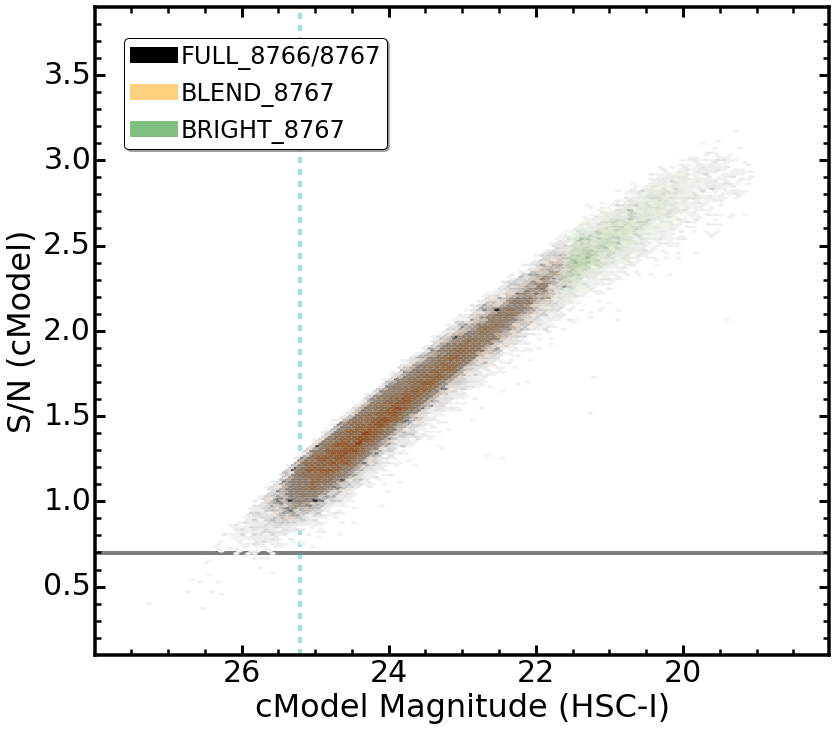

In [49]:
xx1, yy1 = photoI1['cmodel.mag'], np.log10(photoI1['cmodel.flux'] / photoI1['cmodel.flux.err'])
xx2, yy2 = photoI2['cmodel.mag'], np.log10(photoI2['cmodel.flux'] / photoI2['cmodel.flux.err'])
xx3, yy3 = photoI3['cmodel.mag'], np.log10(photoI3['cmodel.flux'] / photoI3['cmodel.flux.err'])

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.axhline(np.log10(5.0), linewidth=4.0, linestyle='-', color='k', 
            alpha=0.5, zorder=0)
ax1.axvline(25.2, linewidth=4.0, linestyle='--', color='c', 
            alpha=0.4, zorder=0)

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=1,
                 alpha=1.0, gridsize=[100, 100], label='FULL_8766/8767',
                 marginals=False, vmin=0, vmax=30, facecolor='k', 
                 edgecolor='none')

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=5,
                 alpha=0.5, gridsize=[100, 100], label='BLEND_8767',
                 marginals=False, vmin=10, vmax=100, facecolor='orange', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap2, mincnt=5,
                 alpha=0.5, gridsize=[100, 100], label='BRIGHT_8767',
                 marginals=False, vmin=10, vmax=100, facecolor='g', 
                 edgecolor='none')

ax1.set_xlabel('cModel Magnitude (HSC-I)', size=32)
ax1.set_ylabel('S/N (cModel)', size=32)

ax1.set_xlim(27.99, 18.01)
ax1.set_ylim(0.1, 3.9)

ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.04, 0.78), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.1)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

## Blendedness

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


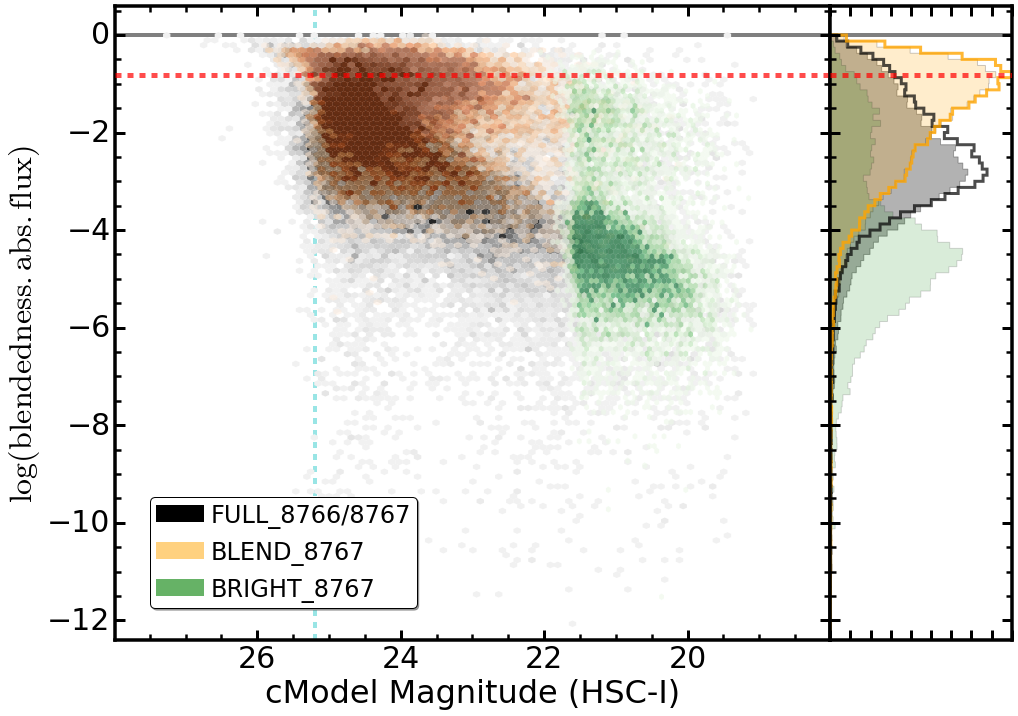

In [50]:
xx1, yy1 = photoI1['cmodel.mag'], np.log10(photoI1['blendedness.abs.flux'])
xx2, yy2 = photoI2['cmodel.mag'], np.log10(photoI2['blendedness.abs.flux'])
xx3, yy3 = photoI3['cmodel.mag'], np.log10(photoI3['blendedness.abs.flux'])

indexFaint1 = np.where(photoI1['mag_i'] >= 22.5)
indexFaint2 = np.where(photoI2['mag_i'] >= 22.5)
indexFaint3 = np.where(photoI3['mag_i'] >= 22.5)

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(14, 10))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ----------------------------------------------------------------------------- #

ax1.axhline(0.0, linewidth=4.0, linestyle='-', color='k', 
            alpha=0.5, zorder=0)
ax1.axvline(25.2, linewidth=4.0, linestyle='--', color='c', 
            alpha=0.4, zorder=0)

ax1.axhline(np.log10(0.15), linewidth=5.0, linestyle='--', color='r', 
            alpha=0.7, zorder=10000)

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=1,
                 alpha=1.0, gridsize=[80, 60], label='FULL_8766/8767',
                 marginals=False, vmin=0, vmax=30, facecolor='k', 
                 edgecolor='none')

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=4,
                 alpha=0.5, gridsize=[80, 60], label='BLEND_8767',
                 marginals=False, vmin=5, vmax=20, facecolor='orange', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap2, mincnt=3,
                 alpha=0.6, gridsize=[80, 60], label='BRIGHT_8767',
                 marginals=False, vmin=5, vmax=20, facecolor='g', 
                 edgecolor='none')

ax1.set_xlabel('cModel Magnitude (HSC-I)', size=32)
ax1.set_ylabel('$\log (\mathrm{blendedness.abs.flux})$', size=32)

ax1.set_xlim(27.99, 18.01)
ax1.set_ylim(-12.4, 0.59)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.05, 0.05), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')


# ----------------------------------------------------------------------------- #

# Histogram 
n, bins, patches=ax2.hist(yy1, bins=100, range=[-12.5, 0.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='k', alpha=0.30, normed=1)
n, bins, patches=ax2.hist(yy3, bins=100, range=[-12.5, 0.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='orange', alpha=0.20, normed=1)
n, bins, patches=ax2.hist(yy2, bins=100, range=[-12.5, 0.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='g', alpha=0.15, normed=1)

n, bins, patches=ax2.hist(yy1[indexFaint1], bins=100, range=[-12.5, 0.0], 
                          orientation='horizontal', histtype='step', 
                          color='k', alpha=0.70, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy3[indexFaint3], bins=100, range=[-12.5, 0.0], 
                          orientation='horizontal', histtype='step', 
                          color='orange', alpha=0.80, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy2[indexFaint2], bins=100, range=[-12.5, 0.0], 
                          orientation='horizontal', histtype='step', 
                          color='g', alpha=0.90, normed=1, linewidth=3.0)

ax2.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)

#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('y', length=6, width=2.5, which='minor')
ax2.tick_params('x', length=0, width=1.0, which='minor')

ax2.axhline(0.0, linewidth=4.0, linestyle='-', color='k', 
            alpha=0.5, zorder=0)

ax2.axhline(np.log10(0.15), linewidth=5.0, linestyle='--', color='r', 
            alpha=0.7, zorder=10000)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

# ----------------------------------------------------------------------------- #

### Combine Samples

In [14]:
from astropy.table import vstack

fakePhoto = vstack([photoI1, photoI2, photoI3])

In [15]:
fakeIsolate = vstack([isolateI1, isolateI2, isolateI3])
fakeNearStar = vstack([nearStarI1, nearStarI2, nearStarI3])
fakeBlended = vstack([blendedI1, blendedI2, blendedI3])

In [102]:
len(photoI1), len(photoG1), len(photoR1)

(59766, 30195, 57651)

In [105]:
from astropy.table import join 

photoIG1 = join(photoI1, photoG1, keys='id')
photoIR1 = join(photoI1, photoR1, keys='id')

photoIG2 = join(photoI2, photoG2, keys='id')
photoIR2 = join(photoI2, photoR2, keys='id')

photoIG3 = join(photoI3, photoG3, keys='id')
photoIR3 = join(photoI3, photoR3, keys='id')

In [107]:
blendedIG1 = join(blendedI1, blendedG1, keys='id')
blendedIR1 = join(blendedI1, blendedR1, keys='id')

blendedIG2 = join(blendedI2, blendedG2, keys='id')
blendedIR2 = join(blendedI2, blendedR2, keys='id')

blendedIG3 = join(blendedI3, blendedG3, keys='id')
blendedIR3 = join(blendedI3, blendedR3, keys='id')

nearStarIG1 = join(nearStarI1, nearStarG1, keys='id')
nearStarIR1 = join(nearStarI1, nearStarR1, keys='id')

nearStarIG2 = join(nearStarI2, nearStarG2, keys='id')
nearStarIR2 = join(nearStarI2, nearStarR2, keys='id')

nearStarIG3 = join(nearStarI3, nearStarG3, keys='id')
nearStarIR3 = join(nearStarI3, nearStarR3, keys='id')

In [108]:
photoIG = vstack([photoIG1, photoIG2, photoIG3])
photoIR = vstack([photoIR1, photoIR2, photoIR3])

blendedIG = vstack([blendedIG1, blendedIG2, blendedIG3])
blendedIR = vstack([blendedIR1, blendedIR2, blendedIR3])

nearStarIG = vstack([nearStarIG1, nearStarIG2, nearStarIG3])
nearStarIR = vstack([nearStarIR1, nearStarIR2, nearStarIR3])

# Key Plots

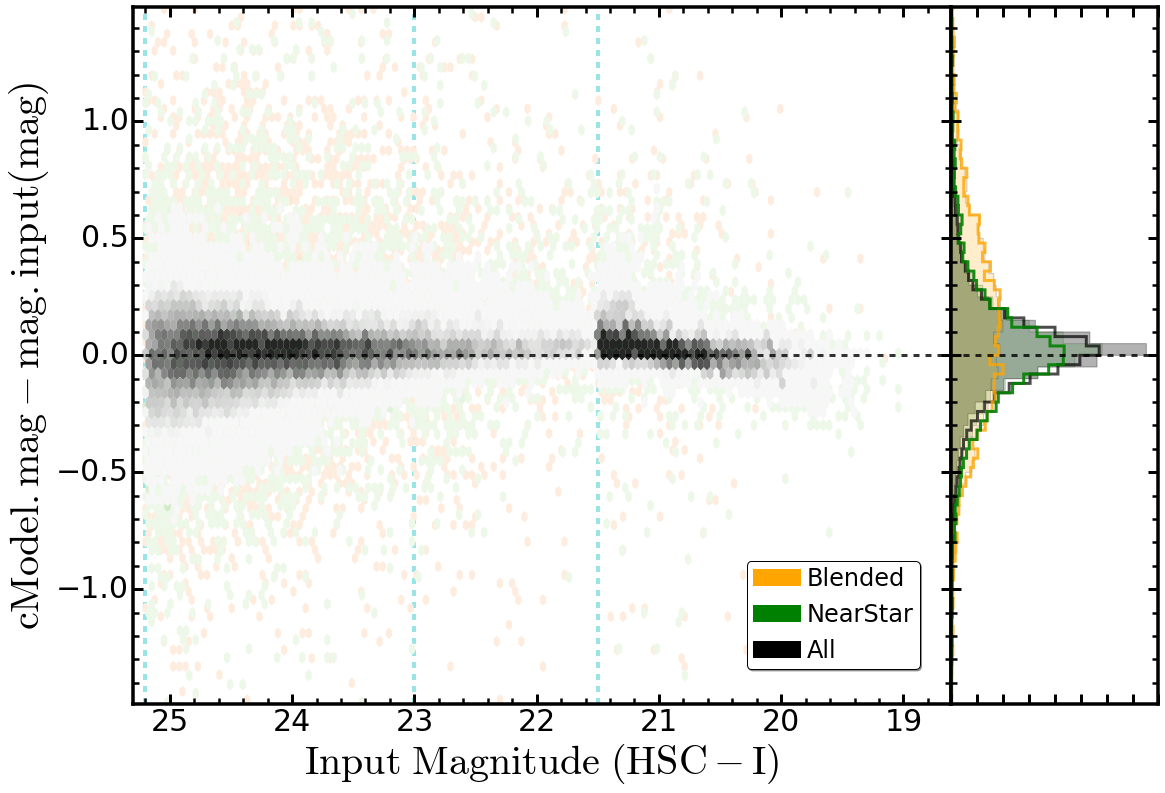

In [57]:
xx1, yy1 = fakePhoto['mag_i'], (fakePhoto['cmodel.mag'] - fakePhoto['mag_i'])
xx2, yy2 = fakeNearStar['mag_i'], (fakeNearStar['cmodel.mag'] - fakeNearStar['mag_i'])
xx3, yy3 = fakeBlended['mag_i'], (fakeBlended['cmodel.mag'] - fakeBlended['mag_i'])

indexFaint1 = np.where(fakePhoto['mag_i'] >= 23.0)
indexFaint2 = np.where(fakeNearStar['mag_i'] >= 23.0)
indexFaint3 = np.where(fakeBlended['mag_i'] >= 23.0)

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(16, 11))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ----------------------------------------------------------------------------- #

ax1.axvline(25.2, linewidth=4.0, linestyle='--', color='c', 
            alpha=0.4, zorder=0)
ax1.axvline(21.5, linewidth=4.0, linestyle='--', color='c', 
            alpha=0.4, zorder=0)
ax1.axvline(23.0, linewidth=4.0, linestyle='--', color='c', 
            alpha=0.4, zorder=0)


hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=1,
                 alpha=1.0, gridsize=[120, 120], label='Blended',
                 marginals=False, vmin=5, vmax=30, facecolor='orange', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap2, mincnt=1,
                 alpha=1.0, gridsize=[120, 120], label='NearStar',
                 marginals=False, vmin=5, vmax=30, facecolor='g', 
                 edgecolor='none')

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=10,
                 alpha=1.0, gridsize=[120, 120], label='All',
                 marginals=False, vmin=40, vmax=200, facecolor='k', 
                 edgecolor='none')

ax1.set_xlabel('$\mathrm{Input\ Magnitude\ (HSC-I)}$', size=32)
ax1.set_ylabel('$\mathrm{cModel.mag} - \mathrm{mag.input (mag)}$', size=32)

ax1.set_xlim(25.3, 18.61)
ax1.set_ylim(-1.49, 1.49)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.75, 0.05), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

ax1.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
            alpha=0.8)

# ----------------------------------------------------------------------------- #

# Histogram 
n, bins, patches=ax2.hist(yy1, bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='k', alpha=0.30, normed=1)
n, bins, patches=ax2.hist(yy3, bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='orange', alpha=0.20, normed=1)
n, bins, patches=ax2.hist(yy2, bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='g', alpha=0.15, normed=1)

n, bins, patches=ax2.hist(yy1[indexFaint1], bins=100, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='k', alpha=0.70, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy3[indexFaint3], bins=100, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='orange', alpha=0.80, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy2[indexFaint2], bins=100, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='g', alpha=0.90, normed=1, linewidth=3.0)

ax2.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)

#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('y', length=6, width=2.5, which='minor')
ax2.tick_params('x', length=0, width=1.0, which='minor')

ax2.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
            alpha=0.8)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

# ----------------------------------------------------------------------------- #

xxU = xx1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyU = yy1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyV = [np.asarray(yyU[(xxU >= 19.2) & (xxU < 20.2)]),
       np.asarray(yyU[(xxU >= 20.2) & (xxU < 21.2)]), 
       np.asarray(yyU[(xxU >= 21.2) & (xxU < 22.2)]),
       np.asarray(yyU[(xxU >= 22.2) & (xxU < 23.2)]),
       np.asarray(yyU[(xxU >= 23.2) & (xxU < 24.2)]), 
       np.asarray(yyU[(xxU >= 24.2) & (xxU < 25.2)])]
vplot1 = ax1.violinplot(yyV, positions=[19.9, 20.9, 21.9, 22.9, 23.9, 24.9],  
                        vert=True, widths=0.2, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot1['bodies']:
    pc.set_facecolor('k')
    pc.set_edgecolor('k')
    pc.set_alpha(0.3)
pm = vplot1['cmedians']
pm.set_linewidths=5.0               

xxU = xx2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyU = yy2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyV = [np.asarray(yyU[(xxU >= 19.2) & (xxU < 20.2)]),
       np.asarray(yyU[(xxU >= 20.2) & (xxU < 21.2)]), 
       np.asarray(yyU[(xxU >= 21.2) & (xxU < 22.2)]),
       np.asarray(yyU[(xxU >= 22.2) & (xxU < 23.2)]),
       np.asarray(yyU[(xxU >= 23.2) & (xxU < 24.2)]), 
       np.asarray(yyU[(xxU >= 24.2) & (xxU < 25.2)])]
vplot2 = ax1.violinplot(yyV, positions=[19.5, 20.5, 21.5, 22.5, 23.5, 24.5], 
                        vert=True, widths=0.2, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot2['bodies']:
    pc.set_facecolor('g')
    pc.set_edgecolor('g')
    pc.set_alpha(0.4)
  
xxU = xx3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyU = yy3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyV = [np.asarray(yyU[(xxU >= 19.2) & (xxU < 20.2)]),
       np.asarray(yyU[(xxU >= 20.2) & (xxU < 21.2)]), 
       np.asarray(yyU[(xxU >= 21.2) & (xxU < 22.2)]),
       np.asarray(yyU[(xxU >= 22.2) & (xxU < 23.2)]),
       np.asarray(yyU[(xxU >= 23.2) & (xxU < 24.2)]), 
       np.asarray(yyU[(xxU >= 24.2) & (xxU < 25.2)])]
vplot3 = ax1.violinplot(yyV, positions=[19.7, 20.7, 21.7, 22.7, 23.7, 24.7], 
                        vert=True, widths=0.2, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot3['bodies']:
    pc.set_facecolor('orange')
    pc.set_edgecolor('orange')
    pc.set_alpha(0.4)

# ----------------------------------------------------------------------------- #

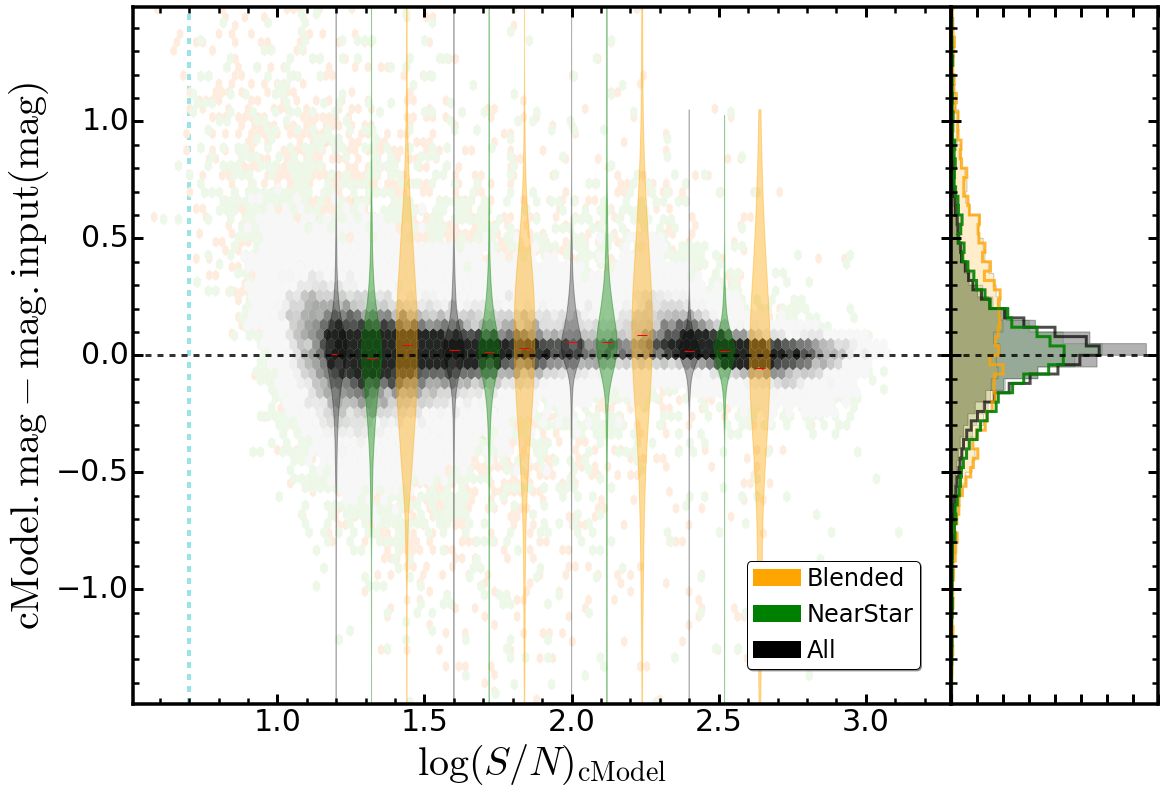

In [62]:
xx1, yy1 = np.log10(fakePhoto['cmodel.flux'] / fakePhoto['cmodel.flux.err']), (fakePhoto['cmodel.mag'] - fakePhoto['mag_i'])
xx2, yy2 = np.log10(fakeNearStar['cmodel.flux'] / fakeNearStar['cmodel.flux.err']), (fakeNearStar['cmodel.mag'] - fakeNearStar['mag_i'])
xx3, yy3 = np.log10(fakeBlended['cmodel.flux'] / fakeBlended['cmodel.flux.err']), (fakeBlended['cmodel.mag'] - fakeBlended['mag_i'])

indexFaint1 = np.where(fakePhoto['mag_i'] >= 23.0)
indexFaint2 = np.where(fakeNearStar['mag_i'] >= 23.0)
indexFaint3 = np.where(fakeBlended['mag_i'] >= 23.0)

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(16, 11))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ----------------------------------------------------------------------------- #

ax1.axvline(np.log10(5.0), linewidth=4.0, linestyle='--', color='c', 
            alpha=0.4, zorder=0)

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=1,
                 alpha=1.0, gridsize=[120, 120], label='Blended',
                 marginals=False, vmin=5, vmax=30, facecolor='orange', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap2, mincnt=1,
                 alpha=1.0, gridsize=[120, 120], label='NearStar',
                 marginals=False, vmin=5, vmax=30, facecolor='g', 
                 edgecolor='none')

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=10,
                 alpha=1.0, gridsize=[120, 120], label='All',
                 marginals=False, vmin=40, vmax=200, facecolor='k', 
                 edgecolor='none')

# ----------------------------------------------------------------------------- #


# ----------------------------------------------------------------------------- #
    
ax1.set_xlabel('$\log (S/N)_{\mathrm{cModel}}$', size=40)
ax1.set_ylabel('$\mathrm{cModel.mag} - \mathrm{mag.input (mag)}$', size=40)

ax1.set_xlim(0.51, 3.29)
ax1.set_ylim(-1.49, 1.49)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.75, 0.05), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

ax1.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
            alpha=0.8)

# ----------------------------------------------------------------------------- #

# Histogram 
n, bins, patches=ax2.hist(yy1, bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='k', alpha=0.30, normed=1)
n, bins, patches=ax2.hist(yy3, bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='orange', alpha=0.20, normed=1)
n, bins, patches=ax2.hist(yy2, bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='g', alpha=0.15, normed=1)

n, bins, patches=ax2.hist(yy1[indexFaint1], bins=100, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='k', alpha=0.70, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy3[indexFaint3], bins=100, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='orange', alpha=0.80, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy2[indexFaint2], bins=100, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='g', alpha=0.90, normed=1, linewidth=3.0)

ax2.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)

#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('y', length=6, width=2.5, which='minor')
ax2.tick_params('x', length=0, width=1.0, which='minor')

ax2.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
            alpha=0.8)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())


# ----------------------------------------------------------------------------- #

xxU = xx1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyU = yy1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot1 = ax1.violinplot(yyV, positions=[1.2, 1.6, 2.0, 2.4],  
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot1['bodies']:
    pc.set_facecolor('k')
    pc.set_edgecolor('k')
    pc.set_alpha(0.3)
pm = vplot1['cmedians']
pm.set_linewidths=5.0               

xxU = xx2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyU = yy2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot2 = ax1.violinplot(yyV, positions=[1.32, 1.72, 2.12, 2.52], 
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot2['bodies']:
    pc.set_facecolor('g')
    pc.set_edgecolor('g')
    pc.set_alpha(0.4)
  
xxU = xx3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyU = yy3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot3 = ax1.violinplot(yyV, positions=[1.44, 1.84, 2.24, 2.64], 
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot3['bodies']:
    pc.set_facecolor('orange')
    pc.set_edgecolor('orange')
    pc.set_alpha(0.4)

# ----------------------------------------------------------------------------- #

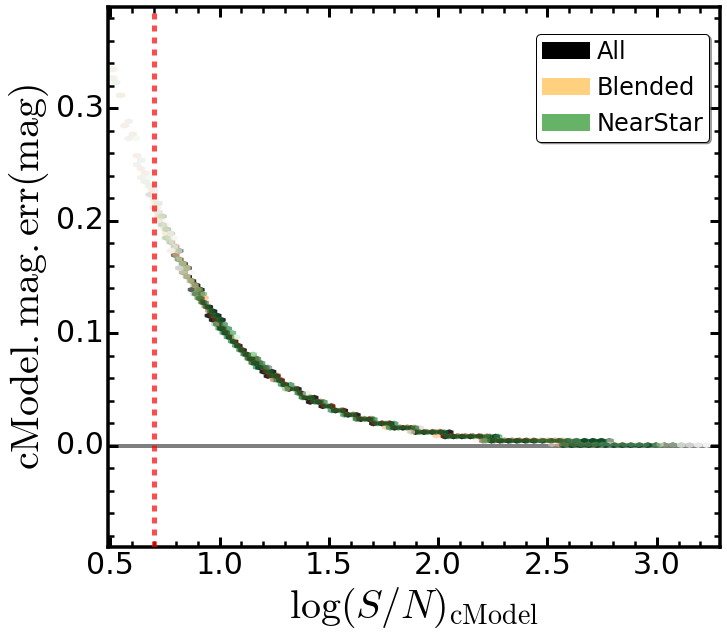

In [68]:
xx1, yy1 = np.log10(fakePhoto['cmodel.flux'] / fakePhoto['cmodel.flux.err']), fakePhoto['cmodel.mag.err']
xx2, yy2 = np.log10(fakeNearStar['cmodel.flux'] / fakeNearStar['cmodel.flux.err']), fakeNearStar['cmodel.mag.err']
xx3, yy3 = np.log10(fakeBlended['cmodel.flux'] / fakeBlended['cmodel.flux.err']), fakeBlended['cmodel.mag.err']

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

# ----------------------------------------------------------------------------- #

ax1.axhline(0.0, linewidth=4.0, linestyle='-', color='k', 
            alpha=0.5, zorder=0)

ax1.axvline(np.log10(5.0), linewidth=5.0, linestyle='--', color='r', 
            alpha=0.7, zorder=10000)

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=1,
                 alpha=1.0, gridsize=[80, 60], label='All',
                 marginals=False, vmin=0, vmax=30, facecolor='k', 
                 edgecolor='none')

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=1,
                 alpha=0.5, gridsize=[80, 60], label='Blended',
                 marginals=False, vmin=1, vmax=20, facecolor='orange', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap2, mincnt=1,
                 alpha=0.6, gridsize=[80, 60], label='NearStar',
                 marginals=False, vmin=1, vmax=20, facecolor='g', 
                 edgecolor='none')

ax1.set_xlabel('$\log (S/N)_{\mathrm{cModel}}$', size=40)
ax1.set_ylabel('$\mathrm{cModel.mag.err (mag)}$', size=40)

ax1.set_xlim(0.49, 3.29)
ax1.set_ylim(-0.09, 0.39)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.70, 0.75), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

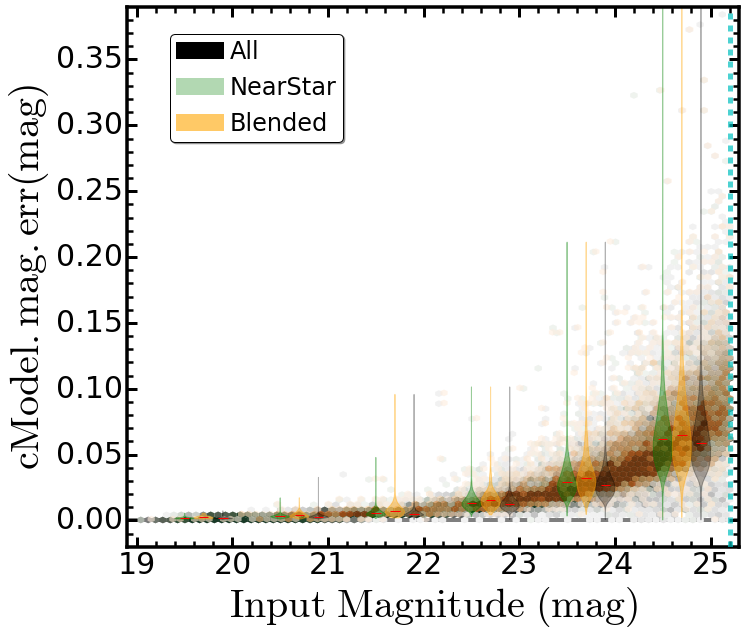

In [137]:
xx1, yy1 = fakePhoto['mag_i'], fakePhoto['cmodel.mag.err']
xx2, yy2 = fakeNearStar['mag_i'], fakeNearStar['cmodel.mag.err']
xx3, yy3 = fakeBlended['mag_i'], fakeBlended['cmodel.mag.err']

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

# ----------------------------------------------------------------------------- #

ax1.axhline(0.0, linewidth=4.0, linestyle='-', color='k', 
            alpha=0.5, zorder=0)

ax1.axvline(25.2, linewidth=5.0, linestyle='--', color='c', 
            alpha=0.7, zorder=10000)

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=1,
                 alpha=1.0, gridsize=[80, 60], label='All',
                 marginals=False, vmin=0, vmax=30, facecolor='k', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap2, mincnt=1,
                 alpha=0.3, gridsize=[80, 60], label='NearStar',
                 marginals=False, vmin=1, vmax=20, facecolor='g', 
                 edgecolor='none')

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=1,
                 alpha=0.6, gridsize=[80, 60], label='Blended',
                 marginals=False, vmin=1, vmax=20, facecolor='orange', 
                 edgecolor='none')

ax1.set_xlabel('$\mathrm{Input\ Magnitude\ (mag)}$', size=40)
ax1.set_ylabel('$\mathrm{cModel.mag.err (mag)}$', size=40)

ax1.set_xlim(18.9, 25.3)
ax1.set_ylim(-0.02, 0.39)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.07, 0.75), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# ----------------------------------------------------------------------------- #

xxU = xx1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyU = yy1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyV = [np.asarray(yyU[(xxU >= 19.2) & (xxU < 20.2)]),
       np.asarray(yyU[(xxU >= 20.2) & (xxU < 21.2)]), 
       np.asarray(yyU[(xxU >= 21.2) & (xxU < 22.2)]),
       np.asarray(yyU[(xxU >= 22.2) & (xxU < 23.2)]),
       np.asarray(yyU[(xxU >= 23.2) & (xxU < 24.2)]), 
       np.asarray(yyU[(xxU >= 24.2) & (xxU < 25.2)])]
vplot1 = ax1.violinplot(yyV, positions=[19.9, 20.9, 21.9, 22.9, 23.9, 24.9],  
                        vert=True, widths=0.2, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot1['bodies']:
    pc.set_facecolor('k')
    pc.set_edgecolor('k')
    pc.set_alpha(0.3)
pm = vplot1['cmedians']
pm.set_linewidths=5.0               

xxU = xx2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyU = yy2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyV = [np.asarray(yyU[(xxU >= 19.2) & (xxU < 20.2)]),
       np.asarray(yyU[(xxU >= 20.2) & (xxU < 21.2)]), 
       np.asarray(yyU[(xxU >= 21.2) & (xxU < 22.2)]),
       np.asarray(yyU[(xxU >= 22.2) & (xxU < 23.2)]),
       np.asarray(yyU[(xxU >= 23.2) & (xxU < 24.2)]), 
       np.asarray(yyU[(xxU >= 24.2) & (xxU < 25.2)])]
vplot2 = ax1.violinplot(yyV, positions=[19.5, 20.5, 21.5, 22.5, 23.5, 24.5], 
                        vert=True, widths=0.2, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot2['bodies']:
    pc.set_facecolor('g')
    pc.set_edgecolor('g')
    pc.set_alpha(0.4)
  
xxU = xx3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyU = yy3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyV = [np.asarray(yyU[(xxU >= 19.2) & (xxU < 20.2)]),
       np.asarray(yyU[(xxU >= 20.2) & (xxU < 21.2)]), 
       np.asarray(yyU[(xxU >= 21.2) & (xxU < 22.2)]),
       np.asarray(yyU[(xxU >= 22.2) & (xxU < 23.2)]),
       np.asarray(yyU[(xxU >= 23.2) & (xxU < 24.2)]), 
       np.asarray(yyU[(xxU >= 24.2) & (xxU < 25.2)])]
vplot3 = ax1.violinplot(yyV, positions=[19.7, 20.7, 21.7, 22.7, 23.7, 24.7], 
                        vert=True, widths=0.2, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot3['bodies']:
    pc.set_facecolor('orange')
    pc.set_edgecolor('orange')
    pc.set_alpha(0.4)

# ----------------------------------------------------------------------------- #

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


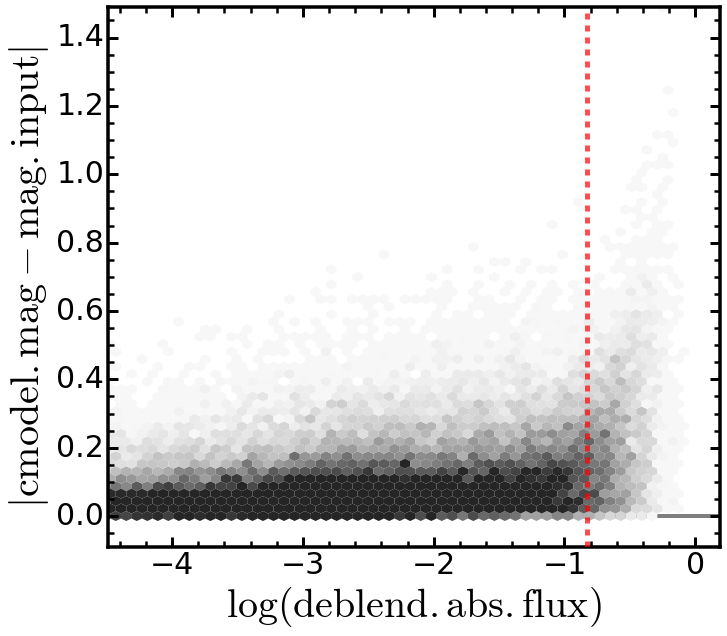

In [124]:
xx1, yy1 = np.log10(fakePhoto['blendedness.abs.flux']), np.abs(fakePhoto['cmodel.mag'] - fakePhoto['mag_i'])
xx2, yy2 = np.log10(fakeNearStar['blendedness.abs.flux']), np.abs(fakeNearStar['cmodel.mag'] - fakeNearStar['mag_i'])
xx3, yy3 = np.log10(fakeBlended['blendedness.abs.flux']), np.abs(fakeBlended['cmodel.mag'] - fakeBlended['mag_i'])

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

# ----------------------------------------------------------------------------- #

ax1.axhline(0.0, linewidth=4.0, linestyle='-', color='k', 
            alpha=0.5, zorder=0)

ax1.axvline(np.log10(0.15), linewidth=5.0, linestyle='--', color='r', 
            alpha=0.7, zorder=10000)

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=5,
                 alpha=1.0, gridsize=[150, 150], label='All',
                 marginals=False, vmin=10, vmax=100, facecolor='k', 
                 edgecolor='none')

ax1.set_xlabel('$\log (\mathrm{deblend.abs.flux})$', size=40)
ax1.set_ylabel('$|\mathrm{cmodel.mag} - \mathrm{mag.input}|$', size=40)

ax1.set_xlim(-4.49, 0.19)
ax1.set_ylim(-0.09, 1.49)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


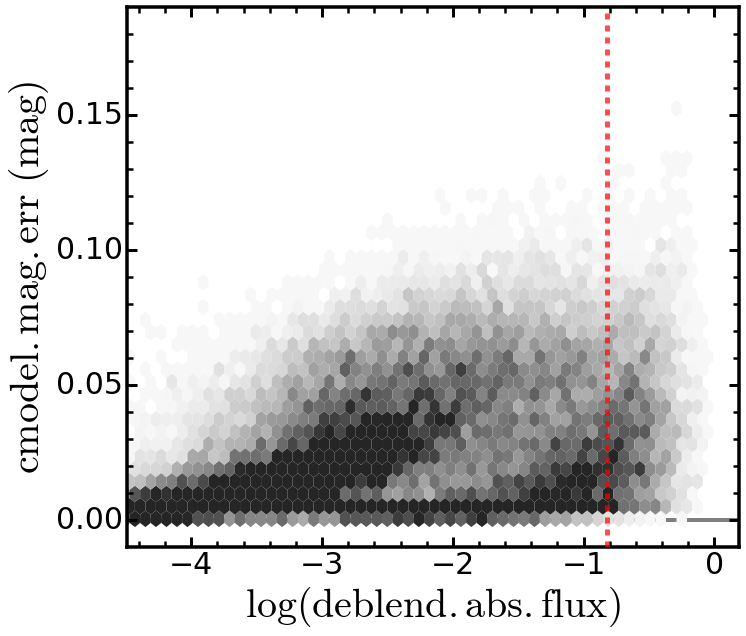

In [128]:
xx1, yy1 = np.log10(fakePhoto['blendedness.abs.flux']), np.abs(fakePhoto['cmodel.mag.err'])
xx2, yy2 = np.log10(fakeNearStar['blendedness.abs.flux']), np.abs(fakeNearStar['cmodel.mag.err'])
xx3, yy3 = np.log10(fakeBlended['blendedness.abs.flux']), np.abs(fakeBlended['cmodel.mag.err'])

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

# ----------------------------------------------------------------------------- #

ax1.axhline(0.0, linewidth=4.0, linestyle='-', color='k', 
            alpha=0.5, zorder=0)

ax1.axvline(np.log10(0.15), linewidth=5.0, linestyle='--', color='r', 
            alpha=0.7, zorder=10000)

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=5,
                 alpha=1.0, gridsize=[150, 50], label='All',
                 marginals=False, vmin=10, vmax=100, facecolor='k', 
                 edgecolor='none')

ax1.set_xlabel('$\log (\mathrm{deblend.abs.flux})$', size=40)
ax1.set_ylabel('$\mathrm{cmodel.mag.err\ (mag)}$', size=40)

ax1.set_xlim(-4.49, 0.19)
ax1.set_ylim(-0.01, 0.19)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

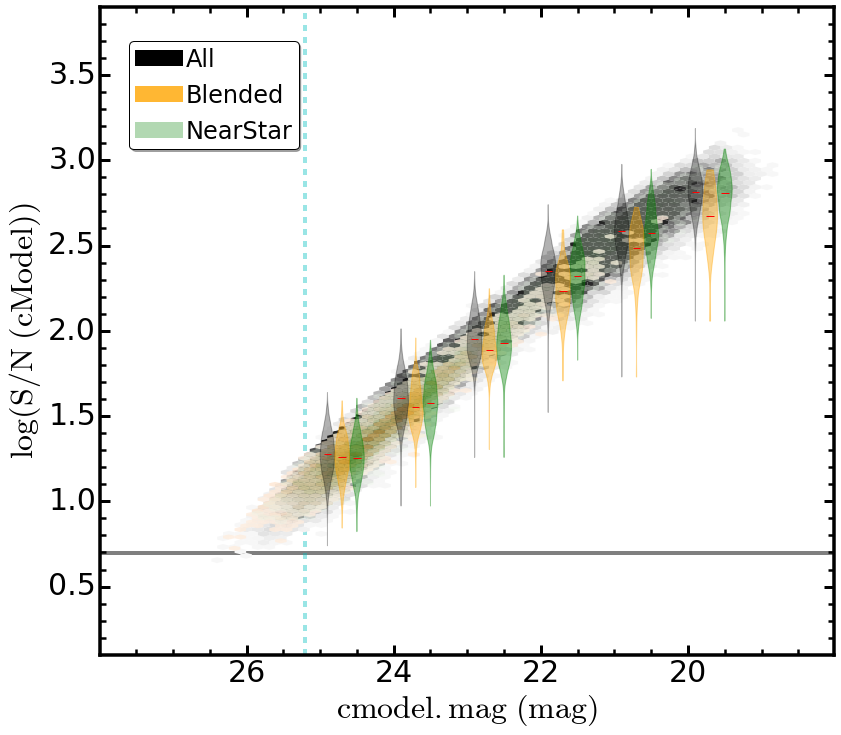

In [218]:
xx1, yy1 = fakePhoto['cmodel.mag'], np.log10(fakePhoto['cmodel.flux'] / fakePhoto['cmodel.flux.err'])
xx2, yy2 = fakeNearStar['cmodel.mag'], np.log10(fakeNearStar['cmodel.flux'] / fakeNearStar['cmodel.flux.err'])
xx3, yy3 = fakeBlended['cmodel.mag'], np.log10(fakeBlended['cmodel.flux'] / fakeBlended['cmodel.flux.err'])

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.axhline(np.log10(5.0), linewidth=4.0, linestyle='-', color='k', 
            alpha=0.5, zorder=0)
ax1.axvline(25.2, linewidth=4.0, linestyle='--', color='c', 
            alpha=0.4, zorder=0)

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=3,
                 alpha=1.0, gridsize=[60, 60], label='All',
                 marginals=False, vmin=5, vmax=100, facecolor='k', 
                 edgecolor='none')

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=3,
                 alpha=0.8, gridsize=[60, 60], label='Blended',
                 marginals=False, vmin=5, vmax=100, facecolor='orange', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap2, mincnt=5,
                 alpha=0.3, gridsize=[60, 60], label='NearStar',
                 marginals=False, vmin=5, vmax=100, facecolor='g', 
                 edgecolor='none')

ax1.set_xlabel('$\mathrm{cmodel.mag\ (mag)}$', size=32)
ax1.set_ylabel('$\log(\mathrm{S/N\ (cModel)})$', size=32)

ax1.set_xlim(27.99, 18.01)
ax1.set_ylim(0.1, 3.9)

ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.04, 0.78), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.1)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

# ----------------------------------------------------------------------------- #

xxU = xx1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyU = yy1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyV = [np.asarray(yyU[(xxU >= 19.2) & (xxU < 20.2)]),
       np.asarray(yyU[(xxU >= 20.2) & (xxU < 21.2)]), 
       np.asarray(yyU[(xxU >= 21.2) & (xxU < 22.2)]),
       np.asarray(yyU[(xxU >= 22.2) & (xxU < 23.2)]),
       np.asarray(yyU[(xxU >= 23.2) & (xxU < 24.2)]), 
       np.asarray(yyU[(xxU >= 24.2) & (xxU < 25.2)])]
vplot1 = ax1.violinplot(yyV, positions=[19.9, 20.9, 21.9, 22.9, 23.9, 24.9],  
                        vert=True, widths=0.2, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot1['bodies']:
    pc.set_facecolor('k')
    pc.set_edgecolor('k')
    pc.set_alpha(0.3)
pm = vplot1['cmedians']
pm.set_linewidths=5.0               

xxU = xx2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyU = yy2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyV = [np.asarray(yyU[(xxU >= 19.2) & (xxU < 20.2)]),
       np.asarray(yyU[(xxU >= 20.2) & (xxU < 21.2)]), 
       np.asarray(yyU[(xxU >= 21.2) & (xxU < 22.2)]),
       np.asarray(yyU[(xxU >= 22.2) & (xxU < 23.2)]),
       np.asarray(yyU[(xxU >= 23.2) & (xxU < 24.2)]), 
       np.asarray(yyU[(xxU >= 24.2) & (xxU < 25.2)])]
vplot2 = ax1.violinplot(yyV, positions=[19.5, 20.5, 21.5, 22.5, 23.5, 24.5], 
                        vert=True, widths=0.2, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot2['bodies']:
    pc.set_facecolor('g')
    pc.set_edgecolor('g')
    pc.set_alpha(0.4)
  
xxU = xx3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyU = yy3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyV = [np.asarray(yyU[(xxU >= 19.2) & (xxU < 20.2)]),
       np.asarray(yyU[(xxU >= 20.2) & (xxU < 21.2)]), 
       np.asarray(yyU[(xxU >= 21.2) & (xxU < 22.2)]),
       np.asarray(yyU[(xxU >= 22.2) & (xxU < 23.2)]),
       np.asarray(yyU[(xxU >= 23.2) & (xxU < 24.2)]), 
       np.asarray(yyU[(xxU >= 24.2) & (xxU < 25.2)])]
vplot3 = ax1.violinplot(yyV, positions=[19.7, 20.7, 21.7, 22.7, 23.7, 24.7], 
                        vert=True, widths=0.2, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot3['bodies']:
    pc.set_facecolor('orange')
    pc.set_edgecolor('orange')
    pc.set_alpha(0.4)

# ----------------------------------------------------------------------------- #

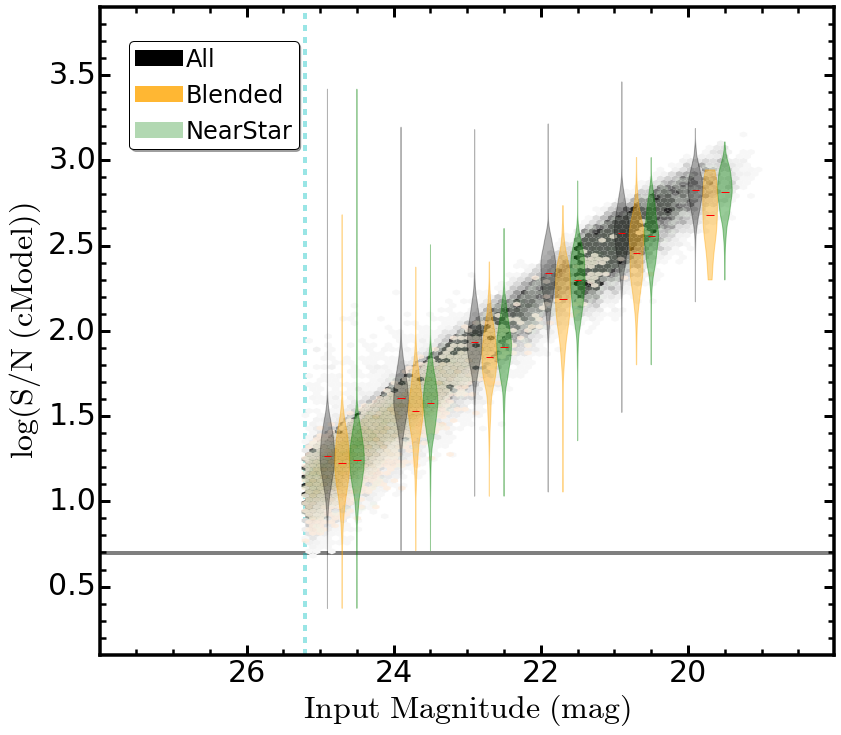

In [145]:
xx1, yy1 = fakePhoto['mag_i'], np.log10(fakePhoto['cmodel.flux'] / fakePhoto['cmodel.flux.err'])
xx2, yy2 = fakeNearStar['mag_i'], np.log10(fakeNearStar['cmodel.flux'] / fakeNearStar['cmodel.flux.err'])
xx3, yy3 = fakeBlended['mag_i'], np.log10(fakeBlended['cmodel.flux'] / fakeBlended['cmodel.flux.err'])

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
ax1 = fig.add_subplot(111)

ax1.axhline(np.log10(5.0), linewidth=4.0, linestyle='-', color='k', 
            alpha=0.5, zorder=0)
ax1.axvline(25.2, linewidth=4.0, linestyle='--', color='c', 
            alpha=0.4, zorder=0)

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=3,
                 alpha=1.0, gridsize=[60, 60], label='All',
                 marginals=False, vmin=5, vmax=100, facecolor='k', 
                 edgecolor='none')

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=3,
                 alpha=0.8, gridsize=[60, 60], label='Blended',
                 marginals=False, vmin=5, vmax=100, facecolor='orange', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap2, mincnt=5,
                 alpha=0.3, gridsize=[60, 60], label='NearStar',
                 marginals=False, vmin=5, vmax=100, facecolor='g', 
                 edgecolor='none')

ax1.set_xlabel('$\mathrm{Input\ Magnitude\ (mag)}$', size=32)
ax1.set_ylabel('$\log(\mathrm{S/N\ (cModel)})$', size=32)

ax1.set_xlim(27.99, 18.01)
ax1.set_ylim(0.1, 3.9)

ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.04, 0.78), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.1)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

# ----------------------------------------------------------------------------- #

xxU = xx1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyU = yy1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyV = [np.asarray(yyU[(xxU >= 19.2) & (xxU < 20.2)]),
       np.asarray(yyU[(xxU >= 20.2) & (xxU < 21.2)]), 
       np.asarray(yyU[(xxU >= 21.2) & (xxU < 22.2)]),
       np.asarray(yyU[(xxU >= 22.2) & (xxU < 23.2)]),
       np.asarray(yyU[(xxU >= 23.2) & (xxU < 24.2)]), 
       np.asarray(yyU[(xxU >= 24.2) & (xxU < 25.2)])]
vplot1 = ax1.violinplot(yyV, positions=[19.9, 20.9, 21.9, 22.9, 23.9, 24.9],  
                        vert=True, widths=0.2, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot1['bodies']:
    pc.set_facecolor('k')
    pc.set_edgecolor('k')
    pc.set_alpha(0.3)
pm = vplot1['cmedians']
pm.set_linewidths=5.0               

xxU = xx2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyU = yy2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyV = [np.asarray(yyU[(xxU >= 19.2) & (xxU < 20.2)]),
       np.asarray(yyU[(xxU >= 20.2) & (xxU < 21.2)]), 
       np.asarray(yyU[(xxU >= 21.2) & (xxU < 22.2)]),
       np.asarray(yyU[(xxU >= 22.2) & (xxU < 23.2)]),
       np.asarray(yyU[(xxU >= 23.2) & (xxU < 24.2)]), 
       np.asarray(yyU[(xxU >= 24.2) & (xxU < 25.2)])]
vplot2 = ax1.violinplot(yyV, positions=[19.5, 20.5, 21.5, 22.5, 23.5, 24.5], 
                        vert=True, widths=0.2, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot2['bodies']:
    pc.set_facecolor('g')
    pc.set_edgecolor('g')
    pc.set_alpha(0.4)
  
xxU = xx3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyU = yy3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyV = [np.asarray(yyU[(xxU >= 19.2) & (xxU < 20.2)]),
       np.asarray(yyU[(xxU >= 20.2) & (xxU < 21.2)]), 
       np.asarray(yyU[(xxU >= 21.2) & (xxU < 22.2)]),
       np.asarray(yyU[(xxU >= 22.2) & (xxU < 23.2)]),
       np.asarray(yyU[(xxU >= 23.2) & (xxU < 24.2)]), 
       np.asarray(yyU[(xxU >= 24.2) & (xxU < 25.2)])]
vplot3 = ax1.violinplot(yyV, positions=[19.7, 20.7, 21.7, 22.7, 23.7, 24.7], 
                        vert=True, widths=0.2, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot3['bodies']:
    pc.set_facecolor('orange')
    pc.set_edgecolor('orange')
    pc.set_alpha(0.4)

# ----------------------------------------------------------------------------- #

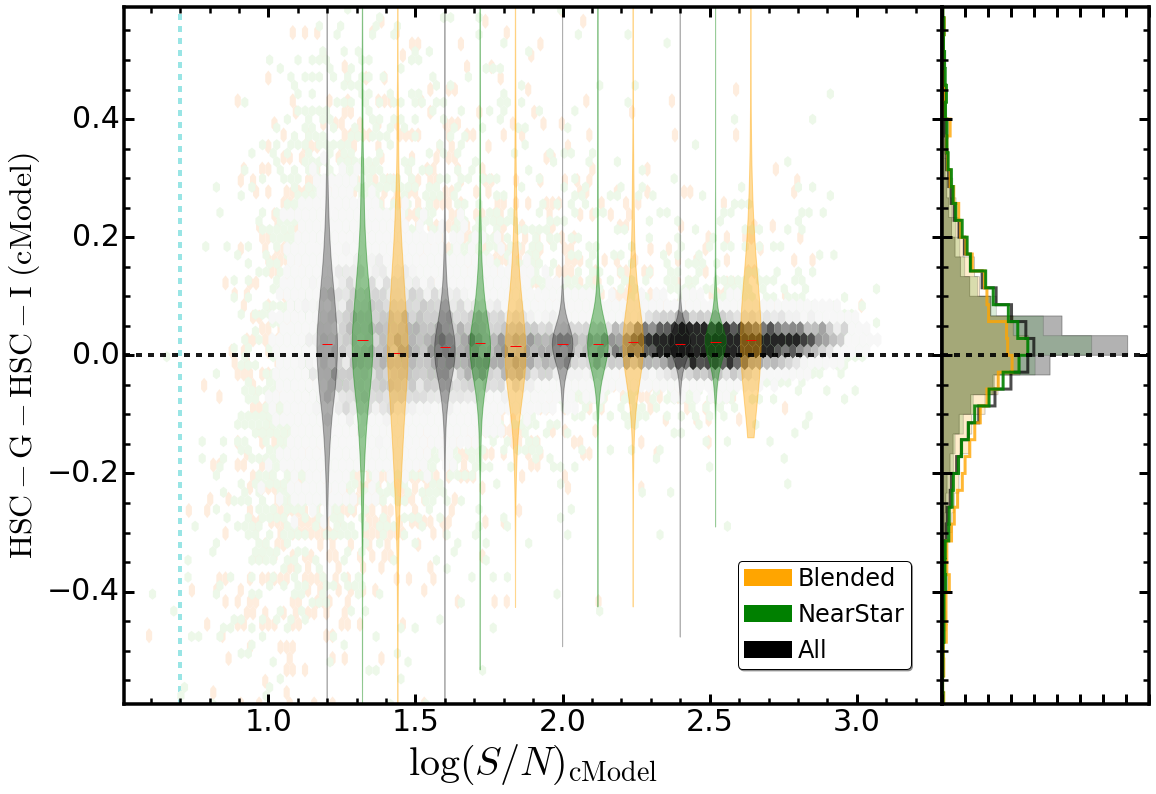

In [215]:
xx1 = np.log10(photoIG['cmodel.flux_1'] / photoIG['cmodel.flux.err_1'])
yy1 = (photoIG['force.cmodel.mag_2'] - photoIG['force.cmodel.mag_1']) - (photoIG['mag_g_1'] - photoIG['mag_i_1'])

xx2 = np.log10(nearStarIG['cmodel.flux_1'] / nearStarIG['cmodel.flux.err_1'])
yy2 = (nearStarIG['force.cmodel.mag_2'] - nearStarIG['force.cmodel.mag_1']) - (nearStarIG['mag_g_1'] - nearStarIG['mag_i_1'])

xx3 = np.log10(blendedIG['cmodel.flux_1'] / blendedIG['cmodel.flux.err_1'])
yy3 = (blendedIG['force.cmodel.mag_2'] - blendedIG['force.cmodel.mag_1']) - (blendedIG['mag_g_1'] - blendedIG['mag_i_1'])


indexFaint1 = np.where(photoIG['mag_i_1'] >= 23.0)
indexFaint2 = np.where(nearStarIG['mag_i_1'] >= 23.0)
indexFaint3 = np.where(blendedIG['mag_i_1'] >= 23.0)

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(16, 11))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ----------------------------------------------------------------------------- #

ax1.axvline(np.log10(5.0), linewidth=4.0, linestyle='--', color='c', 
            alpha=0.4, zorder=0)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=1,
                 alpha=1.0, gridsize=[120, 120], label='Blended',
                 marginals=False, vmin=5, vmax=30, facecolor='orange', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap2, mincnt=1,
                 alpha=1.0, gridsize=[120, 120], label='NearStar',
                 marginals=False, vmin=5, vmax=30, facecolor='g', 
                 edgecolor='none')

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=10,
                 alpha=1.0, gridsize=[120, 120], label='All',
                 marginals=False, vmin=40, vmax=200, facecolor='k', 
                 edgecolor='none')

ax1.set_xlabel('$\log (S/N)_{\mathrm{cModel}}$', size=40)
ax1.set_ylabel('$\mathrm{HSC-G} - \mathrm{HSC-I\ (cModel)}$', size=32)

ax1.set_xlim(0.51, 3.29)
ax1.set_ylim(-0.59, 0.59)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.75, 0.05), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# ----------------------------------------------------------------------------- #

# Histogram 
n, bins, patches=ax2.hist(yy1, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='k', alpha=0.30, normed=1)
n, bins, patches=ax2.hist(yy3, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='orange', alpha=0.20, normed=1)
n, bins, patches=ax2.hist(yy2, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='g', alpha=0.15, normed=1)

n, bins, patches=ax2.hist(yy1[indexFaint1], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='k', alpha=0.70, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy3[indexFaint3], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='orange', alpha=0.80, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy2[indexFaint2], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='g', alpha=0.90, normed=1, linewidth=3.0)

ax2.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

ax2.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)

#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('y', length=6, width=2.5, which='minor')
ax2.tick_params('x', length=0, width=1.0, which='minor')

#ax2.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
#            alpha=0.8)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

# ----------------------------------------------------------------------------- #

xxU = xx1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyU = yy1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot1 = ax1.violinplot(yyV, positions=[1.2, 1.6, 2.0, 2.4],  
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot1['bodies']:
    pc.set_facecolor('k')
    pc.set_edgecolor('k')
    pc.set_alpha(0.3)
pm = vplot1['cmedians']
pm.set_linewidths=5.0               

xxU = xx2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyU = yy2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot2 = ax1.violinplot(yyV, positions=[1.32, 1.72, 2.12, 2.52], 
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot2['bodies']:
    pc.set_facecolor('g')
    pc.set_edgecolor('g')
    pc.set_alpha(0.4)
  
xxU = xx3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyU = yy3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot3 = ax1.violinplot(yyV, positions=[1.44, 1.84, 2.24, 2.64], 
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot3['bodies']:
    pc.set_facecolor('orange')
    pc.set_edgecolor('orange')
    pc.set_alpha(0.4)

# ----------------------------------------------------------------------------- #

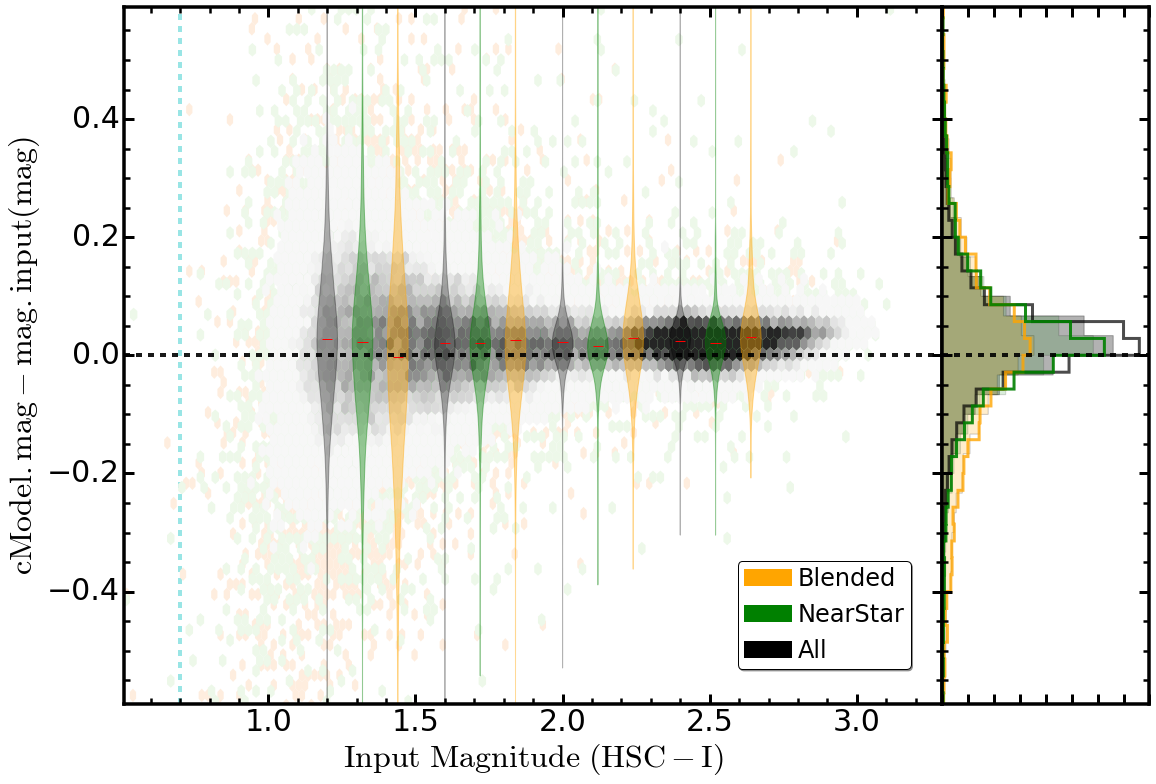

In [147]:
xx1 = np.log10(photoIR['cmodel.flux_1'] / photoIR['cmodel.flux.err_1'])
yy1 = (photoIR['force.cmodel.mag_2'] - photoIR['force.cmodel.mag_1']) - (photoIR['mag_r_1'] - photoIR['mag_i_1'])

xx2 = np.log10(nearStarIR['cmodel.flux_1'] / nearStarIR['cmodel.flux.err_1'])
yy2 = (nearStarIR['force.cmodel.mag_2'] - nearStarIR['force.cmodel.mag_1']) - (nearStarIR['mag_r_1'] - nearStarIR['mag_i_1'])

xx3 = np.log10(blendedIR['cmodel.flux_1'] / blendedIR['cmodel.flux.err_1'])
yy3 = (blendedIR['force.cmodel.mag_2'] - blendedIR['force.cmodel.mag_1']) - (blendedIR['mag_r_1'] - blendedIR['mag_i_1'])


indexFaint1 = np.where(photoIG['mag_i_1'] >= 23.0)
indexFaint2 = np.where(nearStarIG['mag_i_1'] >= 23.0)
indexFaint3 = np.where(blendedIG['mag_i_1'] >= 23.0)

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(16, 11))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ----------------------------------------------------------------------------- #

ax1.axvline(np.log10(5.0), linewidth=4.0, linestyle='--', color='c', 
            alpha=0.4, zorder=0)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=1,
                 alpha=1.0, gridsize=[120, 120], label='Blended',
                 marginals=False, vmin=5, vmax=30, facecolor='orange', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap2, mincnt=1,
                 alpha=1.0, gridsize=[120, 120], label='NearStar',
                 marginals=False, vmin=5, vmax=30, facecolor='g', 
                 edgecolor='none')

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=10,
                 alpha=1.0, gridsize=[120, 120], label='All',
                 marginals=False, vmin=40, vmax=200, facecolor='k', 
                 edgecolor='none')

ax1.set_xlabel('$\log (S/N)_{\mathrm{cModel}}$', size=40)
ax1.set_ylabel('$\mathrm{cModel.mag} - \mathrm{mag.input (mag)}$', size=32)

ax1.set_xlim(0.51, 3.29)
ax1.set_ylim(-0.59, 0.59)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.75, 0.05), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# ----------------------------------------------------------------------------- #

# Histogram 
n, bins, patches=ax2.hist(yy1, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='k', alpha=0.30, normed=1)
n, bins, patches=ax2.hist(yy3, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='orange', alpha=0.20, normed=1)
n, bins, patches=ax2.hist(yy2, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='g', alpha=0.15, normed=1)

n, bins, patches=ax2.hist(yy1[indexFaint1], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='k', alpha=0.70, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy3[indexFaint3], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='orange', alpha=0.80, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy2[indexFaint2], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='g', alpha=0.90, normed=1, linewidth=3.0)

ax2.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

ax2.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)

#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('y', length=6, width=2.5, which='minor')
ax2.tick_params('x', length=0, width=1.0, which='minor')

#ax2.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
#            alpha=0.8)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

# ----------------------------------------------------------------------------- #

xxU = xx1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyU = yy1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot1 = ax1.violinplot(yyV, positions=[1.2, 1.6, 2.0, 2.4],  
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot1['bodies']:
    pc.set_facecolor('k')
    pc.set_edgecolor('k')
    pc.set_alpha(0.3)
pm = vplot1['cmedians']
pm.set_linewidths=5.0               

xxU = xx2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyU = yy2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot2 = ax1.violinplot(yyV, positions=[1.32, 1.72, 2.12, 2.52], 
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot2['bodies']:
    pc.set_facecolor('g')
    pc.set_edgecolor('g')
    pc.set_alpha(0.4)
  
xxU = xx3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyU = yy3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot3 = ax1.violinplot(yyV, positions=[1.44, 1.84, 2.24, 2.64], 
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot3['bodies']:
    pc.set_facecolor('orange')
    pc.set_edgecolor('orange')
    pc.set_alpha(0.4)

# ----------------------------------------------------------------------------- #

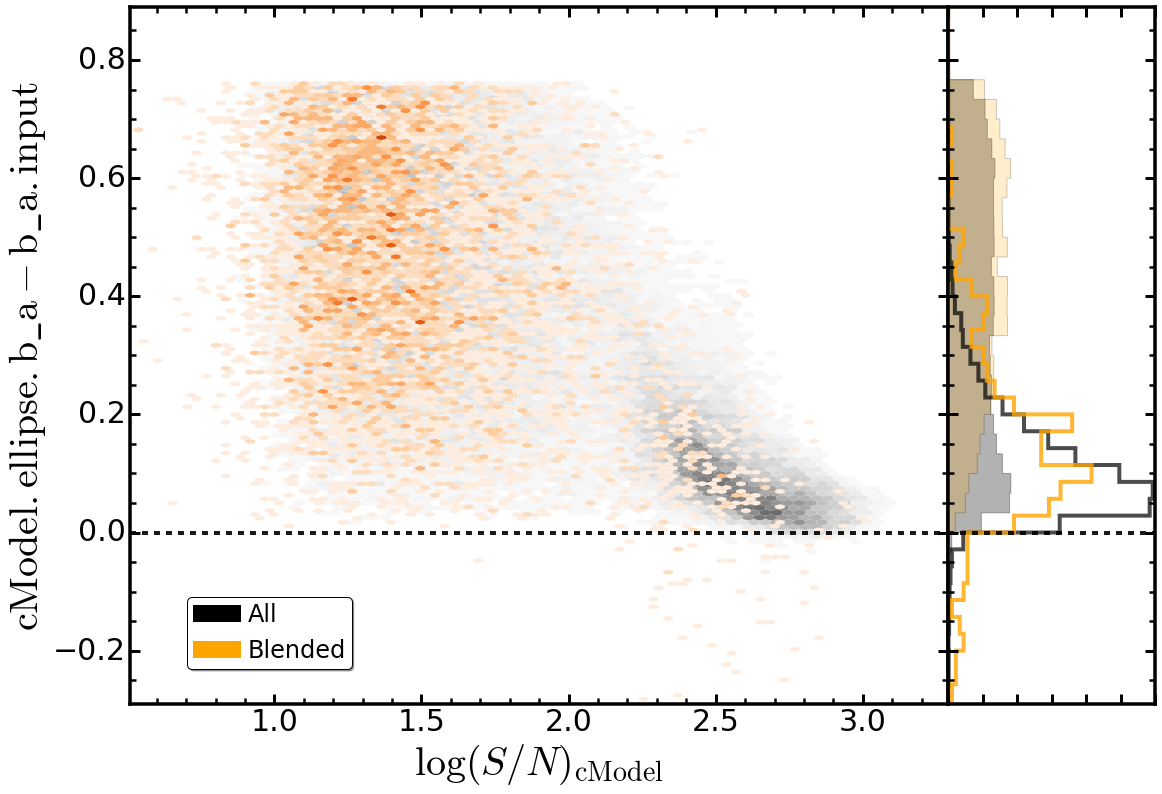

In [170]:
xx1 = np.log10(fakePhoto['cmodel.flux'] / fakePhoto['cmodel.flux.err'])
yy1 = (fakePhoto['cmodel.exp.ellipse_q'] - fakePhoto['b_a'])

xx2 = np.log10(fakeNearStar['cmodel.flux'] / fakeNearStar['cmodel.flux.err'])
yy2 = (fakeNearStar['cmodel.exp.ellipse_q'] - fakeNearStar['b_a'])

xx3 = np.log10(fakeBlended['cmodel.flux'] / fakeBlended['cmodel.flux.err'])
yy3 = (fakeBlended['cmodel.exp.ellipse_q'] - fakeBlended['b_a'])

indexFaint1 = np.where(fakePhoto['mag_i'] <= 21.5)
indexFaint2 = np.where(fakeNearStar['mag_i'] <= 21.5)
indexFaint3 = np.where(fakeBlended['mag_i'] <= 21.5)

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(16, 11))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ----------------------------------------------------------------------------- #

ax1.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=5,
                 alpha=1.0, gridsize=[80, 80], label='All',
                 marginals=False, vmin=10, vmax=200, facecolor='k', 
                 edgecolor='none')

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=1,
                 alpha=1.0, gridsize=[80, 80], label='Blended',
                 marginals=False, vmin=1, vmax=10, facecolor='orange', 
                 edgecolor='none')


ax1.set_xlabel('$\log (S/N)_{\mathrm{cModel}}$', size=40)
ax1.set_ylabel('$\mathrm{cModel.ellipse.b\_a} - \mathrm{b\_a.input}$', size=40)

ax1.set_xlim(0.51, 3.29)
ax1.set_ylim(-0.29, 0.89)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.07, 0.05), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# ----------------------------------------------------------------------------- #

# Histogram 
n, bins, patches=ax2.hist(yy1, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='k', alpha=0.30, normed=1)
n, bins, patches=ax2.hist(yy3, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='orange', alpha=0.20, normed=1)


n, bins, patches=ax2.hist(yy1[indexFaint1], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='k', alpha=0.70, normed=1, linewidth=4.0)
n, bins, patches=ax2.hist(yy3[indexFaint3], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='orange', alpha=0.80, normed=1, linewidth=4.0)


ax2.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

ax2.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)

#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('y', length=6, width=2.5, which='minor')
ax2.tick_params('x', length=0, width=1.0, which='minor')

#ax2.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
#            alpha=0.8)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

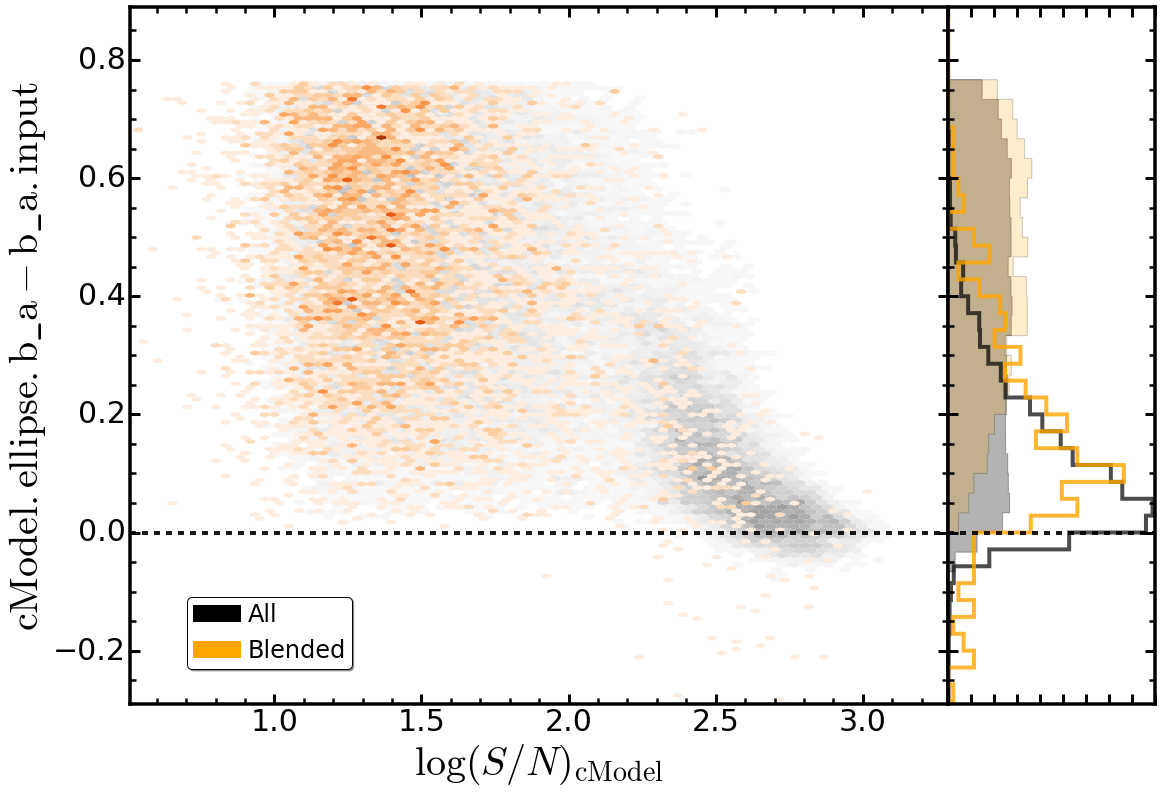

In [177]:
xx1 = np.log10(fakePhoto['cmodel.flux'] / fakePhoto['cmodel.flux.err'])
yy1 = (fakePhoto['cmodel.dev.ellipse_q'] - fakePhoto['b_a'])

xx2 = np.log10(fakeNearStar['cmodel.flux'] / fakeNearStar['cmodel.flux.err'])
yy2 = (fakeNearStar['cmodel.dev.ellipse_q'] - fakeNearStar['b_a'])

xx3 = np.log10(fakeBlended['cmodel.flux'] / fakeBlended['cmodel.flux.err'])
yy3 = (fakeBlended['cmodel.dev.ellipse_q'] - fakeBlended['b_a'])

indexFaint1 = np.where(fakePhoto['mag_i'] <= 21.5)
indexFaint2 = np.where(fakeNearStar['mag_i'] <= 21.5)
indexFaint3 = np.where(fakeBlended['mag_i'] <= 21.5)

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(16, 11))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ----------------------------------------------------------------------------- #

ax1.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=5,
                 alpha=1.0, gridsize=[80, 80], label='All',
                 marginals=False, vmin=10, vmax=200, facecolor='k', 
                 edgecolor='none')

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=1,
                 alpha=1.0, gridsize=[80, 80], label='Blended',
                 marginals=False, vmin=1, vmax=10, facecolor='orange', 
                 edgecolor='none')


ax1.set_xlabel('$\log (S/N)_{\mathrm{cModel}}$', size=40)
ax1.set_ylabel('$\mathrm{cModel.ellipse.b\_a} - \mathrm{b\_a.input}$', size=40)

ax1.set_xlim(0.51, 3.29)
ax1.set_ylim(-0.29, 0.89)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.07, 0.05), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# ----------------------------------------------------------------------------- #

# Histogram 
n, bins, patches=ax2.hist(yy1, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='k', alpha=0.30, normed=1)
n, bins, patches=ax2.hist(yy3, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='orange', alpha=0.20, normed=1)


n, bins, patches=ax2.hist(yy1[indexFaint1], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='k', alpha=0.70, normed=1, linewidth=4.0)
n, bins, patches=ax2.hist(yy3[indexFaint3], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='orange', alpha=0.80, normed=1, linewidth=4.0)


ax2.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

ax2.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)

#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('y', length=6, width=2.5, which='minor')
ax2.tick_params('x', length=0, width=1.0, which='minor')

#ax2.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
#            alpha=0.8)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater_equal


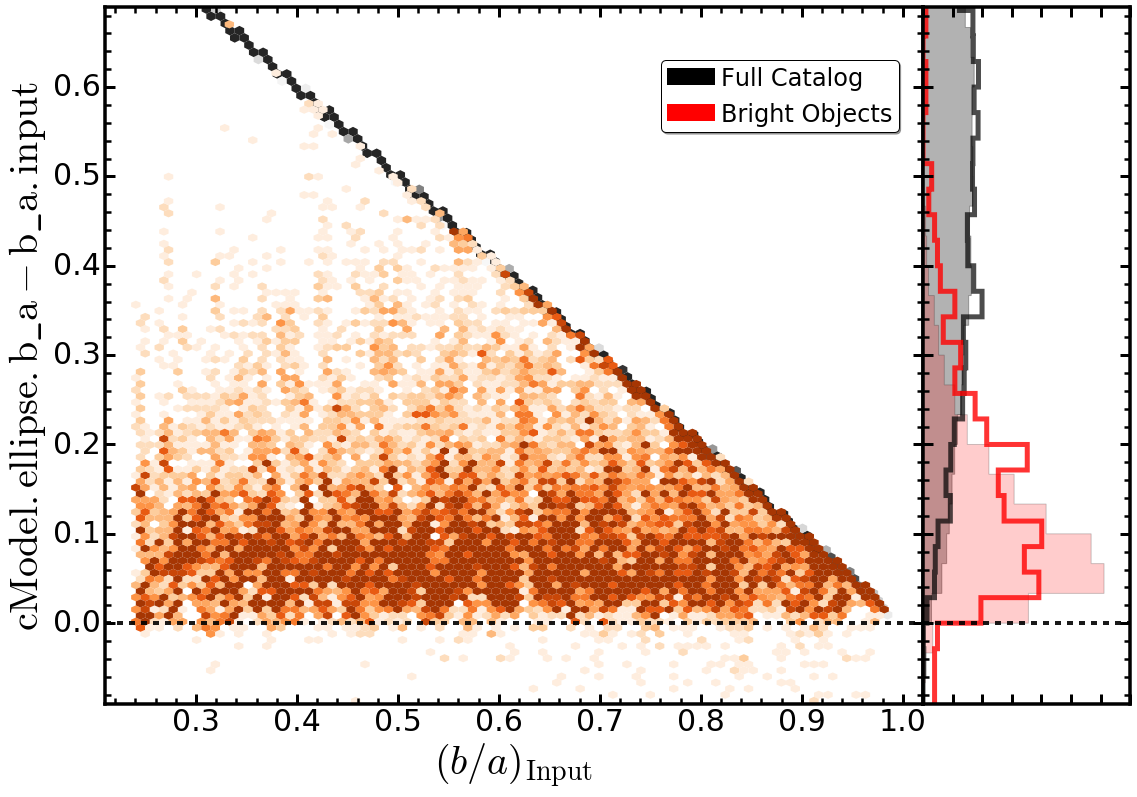

In [201]:
del xx1, yy1, xx2, yy2
xx1 = photoI1['b_a']
yy1 = photoI1['cmodel.exp.ellipse_q'] - photoI1['b_a']

xx2 = photoI2['b_a']
yy2 = photoI2['cmodel.exp.ellipse_q'] - photoI2['b_a']

indexFaint1 = np.where(photoI1['blendedness.abs.flux'] >= 0.15)
indexFaint2 = np.where(photoI2['blendedness.abs.flux'] >= 0.15)

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(16, 11))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ----------------------------------------------------------------------------- #

ax1.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=5,
                 alpha=1.0, gridsize=[80, 80], label='Full Catalog',
                 marginals=False, vmin=10, vmax=200, facecolor='k', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap3, mincnt=1,
                 alpha=1.0, gridsize=[80, 80], label='Bright Objects',
                 marginals=False, vmin=1, vmax=10, facecolor='r', 
                 edgecolor='none')


ax1.set_xlabel('$(b/a)_{\mathrm{Input}}$', size=40)
ax1.set_ylabel('$\mathrm{cModel.ellipse.b\_a} - \mathrm{b\_a.input}$', size=40)

ax1.set_xlim(0.21, 1.02)
ax1.set_ylim(-0.09, 0.69)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.68, 0.82), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# ----------------------------------------------------------------------------- #

# Histogram 
n, bins, patches=ax2.hist(yy1, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='k', alpha=0.30, normed=1)
n, bins, patches=ax2.hist(yy2, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='r', alpha=0.20, normed=1)


n, bins, patches=ax2.hist(yy1[indexFaint1], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='k', alpha=0.70, normed=1, linewidth=5.0)
n, bins, patches=ax2.hist(yy2[indexFaint2], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='r', alpha=0.80, normed=1, linewidth=5.0)


ax2.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

ax2.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)

#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('y', length=6, width=2.5, which='minor')
ax2.tick_params('x', length=0, width=1.0, which='minor')

#ax2.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
#            alpha=0.8)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater_equal


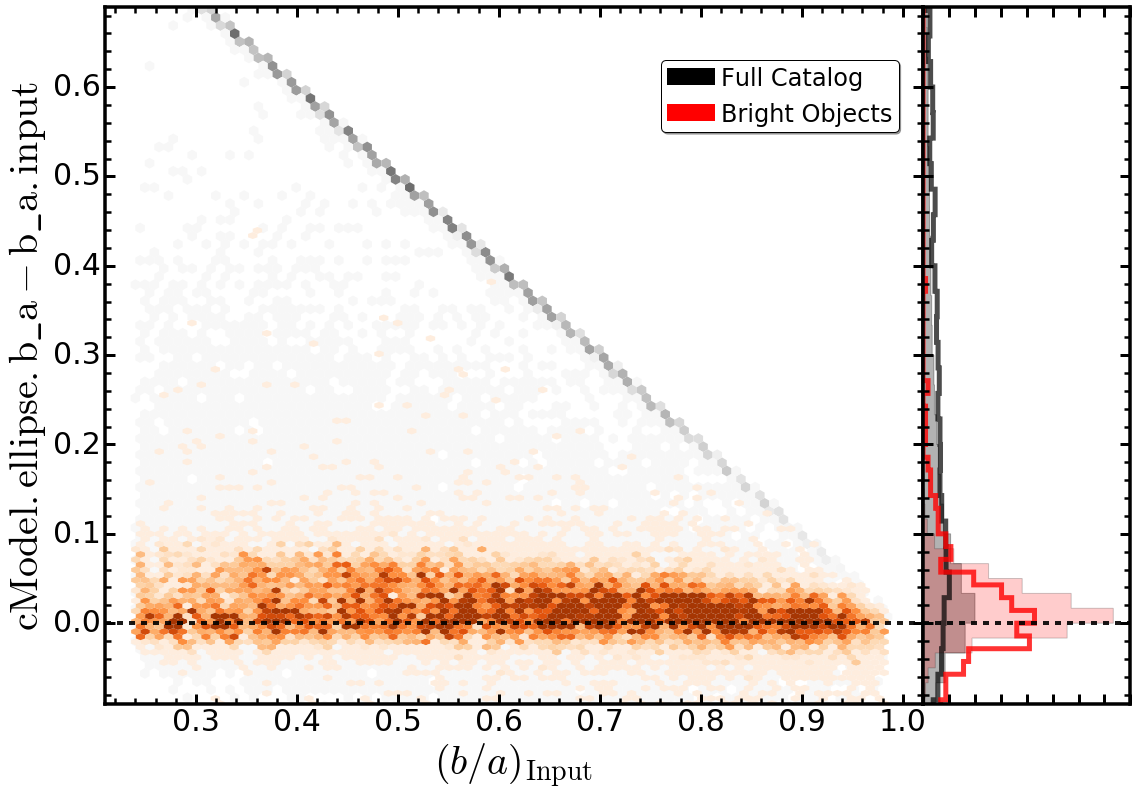

In [202]:
del xx1, yy1, xx2, yy2

xx1 = photoI1['b_a']
yy1 = photoI1['cmodel.initial.ellipse_q'] - photoI1['b_a']

xx2 = photoI2['b_a']
yy2 = photoI2['cmodel.initial.ellipse_q'] - photoI2['b_a']

indexFaint1 = np.where(photoI1['blendedness.abs.flux'] >= 0.15)
indexFaint2 = np.where(photoI2['blendedness.abs.flux'] >= 0.15)

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(16, 11))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ----------------------------------------------------------------------------- #

ax1.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=5,
                 alpha=1.0, gridsize=[80, 80], label='Full Catalog',
                 marginals=False, vmin=30, vmax=200, facecolor='k', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap3, mincnt=1,
                 alpha=1.0, gridsize=[80, 80], label='Bright Objects',
                 marginals=False, vmin=3, vmax=25, facecolor='r', 
                 edgecolor='none')


ax1.set_xlabel('$(b/a)_{\mathrm{Input}}$', size=40)
ax1.set_ylabel('$\mathrm{cModel.ellipse.b\_a} - \mathrm{b\_a.input}$', size=40)

ax1.set_xlim(0.21, 1.02)
ax1.set_ylim(-0.09, 0.69)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.68, 0.82), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# ----------------------------------------------------------------------------- #

# Histogram 
n, bins, patches=ax2.hist(yy1, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='k', alpha=0.30, normed=1)
n, bins, patches=ax2.hist(yy2, bins=120, range=[-1.0, 1.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='r', alpha=0.20, normed=1)


n, bins, patches=ax2.hist(yy1[indexFaint1], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='k', alpha=0.70, normed=1, linewidth=5.0)
n, bins, patches=ax2.hist(yy2[indexFaint2], bins=140, range=[-1.0, 1.0], 
                          orientation='horizontal', histtype='step', 
                          color='r', alpha=0.80, normed=1, linewidth=5.0)


ax2.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

ax2.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)

#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('y', length=6, width=2.5, which='minor')
ax2.tick_params('x', length=0, width=1.0, which='minor')

#ax2.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
#            alpha=0.8)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

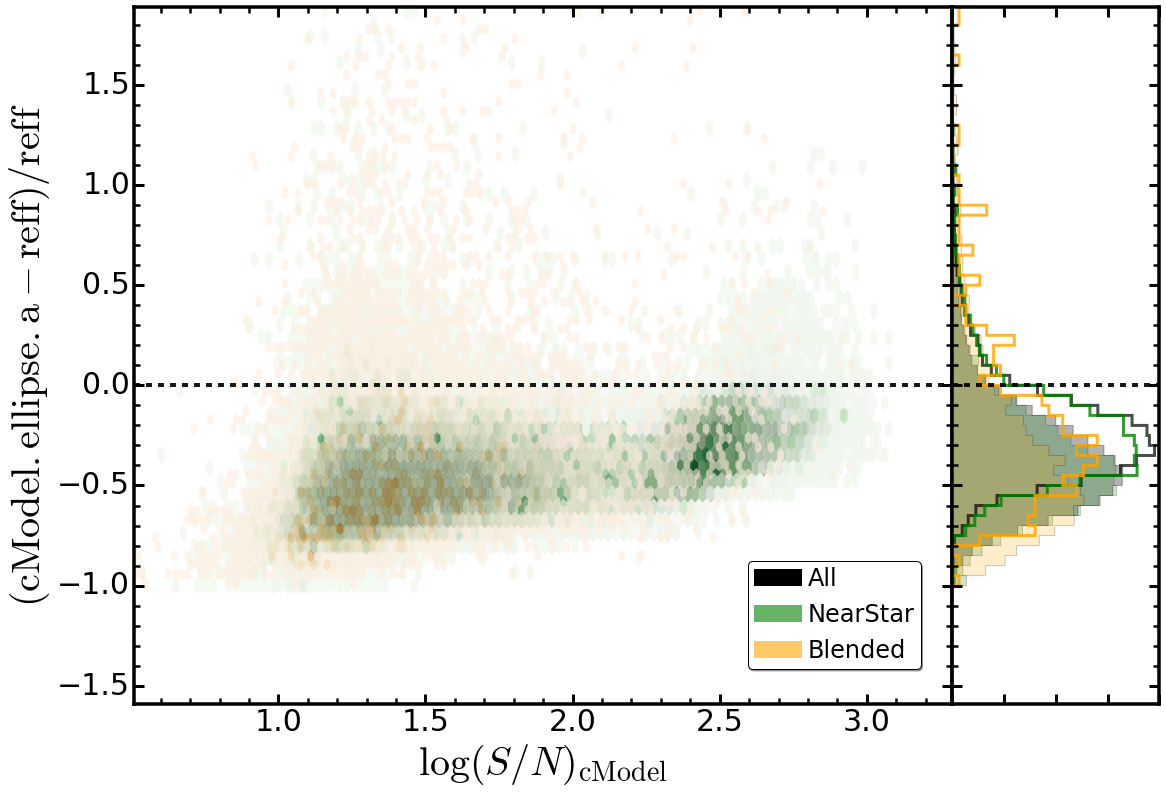

In [267]:
#del xx1, yy1, xx2, yy2, xx3, yy3
xx1 = np.log10(fakePhoto['cmodel.flux'] / fakePhoto['cmodel.flux.err'])
yy1 = (fakePhoto['cmodel.ellipse_a'] - 
       (fakePhoto['reff'] / (fakePhoto['b_a'] * 0.168))) / (fakePhoto['reff'] / (fakePhoto['b_a'] * 0.168))

xx2 = np.log10(fakeNearStar['cmodel.flux'] / fakeNearStar['cmodel.flux.err'])
yy2 = (fakeNearStar['cmodel.ellipse_a'] - 
       (fakeNearStar['reff'] / (fakeNearStar['b_a'] * 0.168))) / (fakeNearStar['reff'] / (fakeNearStar['b_a'] * 0.168))

xx3 = np.log10(fakeBlended['cmodel.flux'] / fakeBlended['cmodel.flux.err'])
yy3 = (fakeBlended['cmodel.ellipse_a'] - 
       (fakeBlended['reff'] / (fakeBlended['b_a'] * 0.168))) / (fakeBlended['reff'] / (fakeBlended['b_a'] * 0.168))

indexFaint1 = np.where(fakePhoto['mag_i'] <= 21.5)
indexFaint2 = np.where(fakeNearStar['mag_i'] <= 21.5)
indexFaint3 = np.where(fakeBlended['mag_i'] <= 21.5)

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(16, 11))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ----------------------------------------------------------------------------- #

ax1.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=10,
                 alpha=1.0, gridsize=[120, 180], label='All',
                 marginals=False, vmin=40, vmax=200, facecolor='k', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap2, mincnt=1,
                 alpha=0.6, gridsize=[120, 180], label='NearStar',
                 marginals=False, vmin=5, vmax=25, facecolor='g', 
                 edgecolor='none')

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=1,
                 alpha=0.6, gridsize=[120, 180], label='Blended',
                 marginals=False, vmin=5, vmax=25, facecolor='orange', 
                 edgecolor='none')


ax1.set_xlabel('$\log (S/N)_{\mathrm{cModel}}$', size=40)
ax1.set_ylabel('$(\mathrm{cModel.ellipse.a} - \mathrm{reff})/ \mathrm{reff}$', size=40)

ax1.set_xlim(0.51, 3.29)
ax1.set_ylim(-1.59, 1.89)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.75, 0.05), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# ----------------------------------------------------------------------------- #

# Histogram 
n, bins, patches=ax2.hist(yy1, bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='k', alpha=0.30, normed=1)
n, bins, patches=ax2.hist(yy2, bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='g', alpha=0.20, normed=1)
n, bins, patches=ax2.hist(yy3, bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='orange', alpha=0.20, normed=1)

n, bins, patches=ax2.hist(yy1[indexFaint1], bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='k', alpha=0.70, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy2[indexFaint2], bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='g', alpha=0.80, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy3[indexFaint3], bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='orange', alpha=0.80, normed=1, linewidth=3.0)

ax2.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

ax2.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)

#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('y', length=6, width=2.5, which='minor')
ax2.tick_params('x', length=0, width=1.0, which='minor')

#ax2.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
#            alpha=0.8)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())


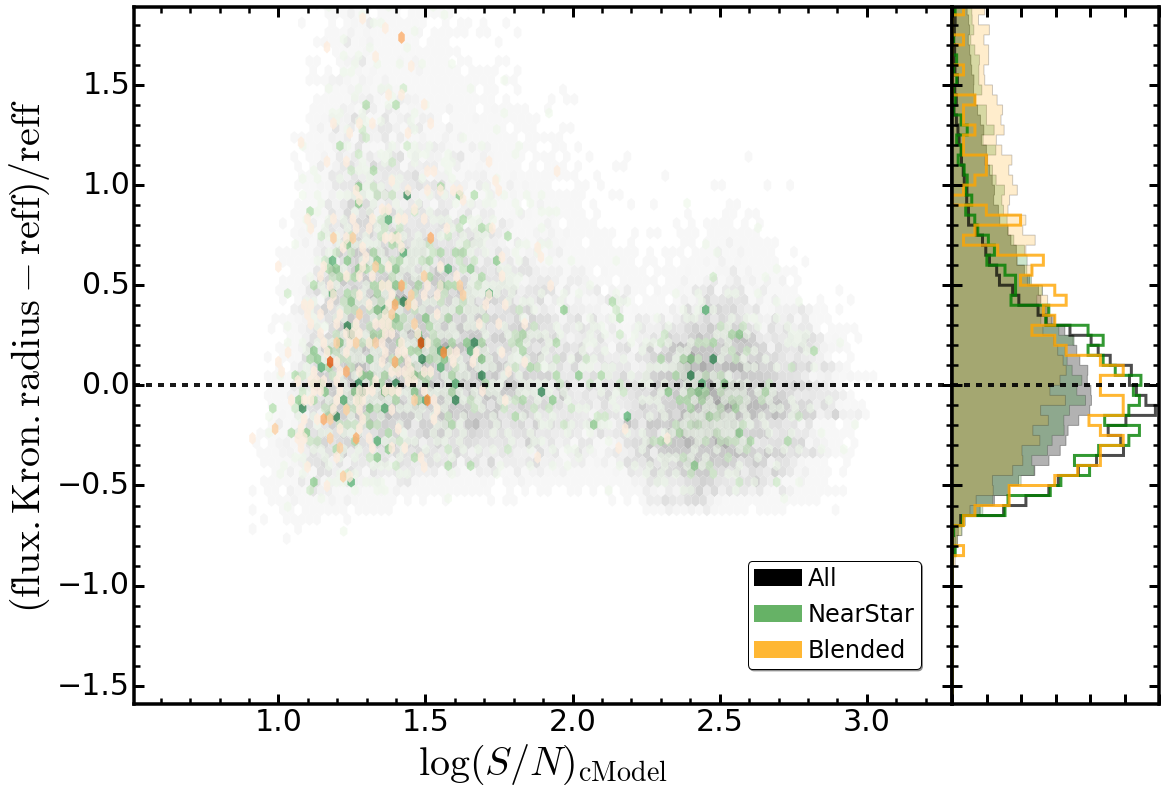

In [269]:
#del xx1, yy1, xx2, yy2, xx3, yy3
xx1 = np.log10(fakePhoto['cmodel.flux'] / fakePhoto['cmodel.flux.err'])
yy1 = (fakePhoto['flux.kron.radius'] - 
       (fakePhoto['reff'] / (fakePhoto['b_a'] * 0.168))) / (fakePhoto['reff'] / (fakePhoto['b_a'] * 0.168))

xx2 = np.log10(fakeNearStar['cmodel.flux'] / fakeNearStar['cmodel.flux.err'])
yy2 = (fakeNearStar['flux.kron.radius'] - 
       (fakeNearStar['reff'] / (fakeNearStar['b_a'] * 0.168))) / (fakeNearStar['reff'] / (fakeNearStar['b_a'] * 0.168))

xx3 = np.log10(fakeBlended['cmodel.flux'] / fakeBlended['cmodel.flux.err'])
yy3 = (fakeBlended['flux.kron.radius'] - 
       (fakeBlended['reff'] / (fakeBlended['b_a'] * 0.168))) / (fakeBlended['reff'] / (fakeBlended['b_a'] * 0.168))

indexFaint1 = np.where(fakePhoto['mag_i'] <= 21.5)
indexFaint2 = np.where(fakeNearStar['mag_i'] <= 21.5)
indexFaint3 = np.where(fakeBlended['mag_i'] <= 21.5)

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(16, 11))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ----------------------------------------------------------------------------- #

ax1.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=10,
                 alpha=1.0, gridsize=[120, 420], label='All',
                 marginals=False, vmin=20, vmax=160, facecolor='k', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap2, mincnt=4,
                 alpha=0.6, gridsize=[120, 420], label='NearStar',
                 marginals=False, vmin=5, vmax=10, facecolor='g', 
                 edgecolor='none')

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=4,
                 alpha=0.8, gridsize=[120, 420], label='Blended',
                 marginals=False, vmin=5, vmax=10, facecolor='orange', 
                 edgecolor='none')


ax1.set_xlabel('$\log (S/N)_{\mathrm{cModel}}$', size=40)
ax1.set_ylabel('$(\mathrm{flux.Kron.radius} - \mathrm{reff})/ \mathrm{reff}$', size=40)

ax1.set_xlim(0.51, 3.29)
ax1.set_ylim(-1.59, 1.89)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.75, 0.05), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# ----------------------------------------------------------------------------- #

# Histogram 
n, bins, patches=ax2.hist(yy1, bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='k', alpha=0.30, normed=1)
n, bins, patches=ax2.hist(yy2, bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='g', alpha=0.20, normed=1)
n, bins, patches=ax2.hist(yy3, bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='orange', alpha=0.20, normed=1)

n, bins, patches=ax2.hist(yy1[indexFaint1], bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='k', alpha=0.70, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy2[indexFaint2], bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='g', alpha=0.80, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy3[indexFaint3], bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='orange', alpha=0.80, normed=1, linewidth=3.0)

ax2.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

ax2.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)

#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('y', length=6, width=2.5, which='minor')
ax2.tick_params('x', length=0, width=1.0, which='minor')

#ax2.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
#            alpha=0.8)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater_equal


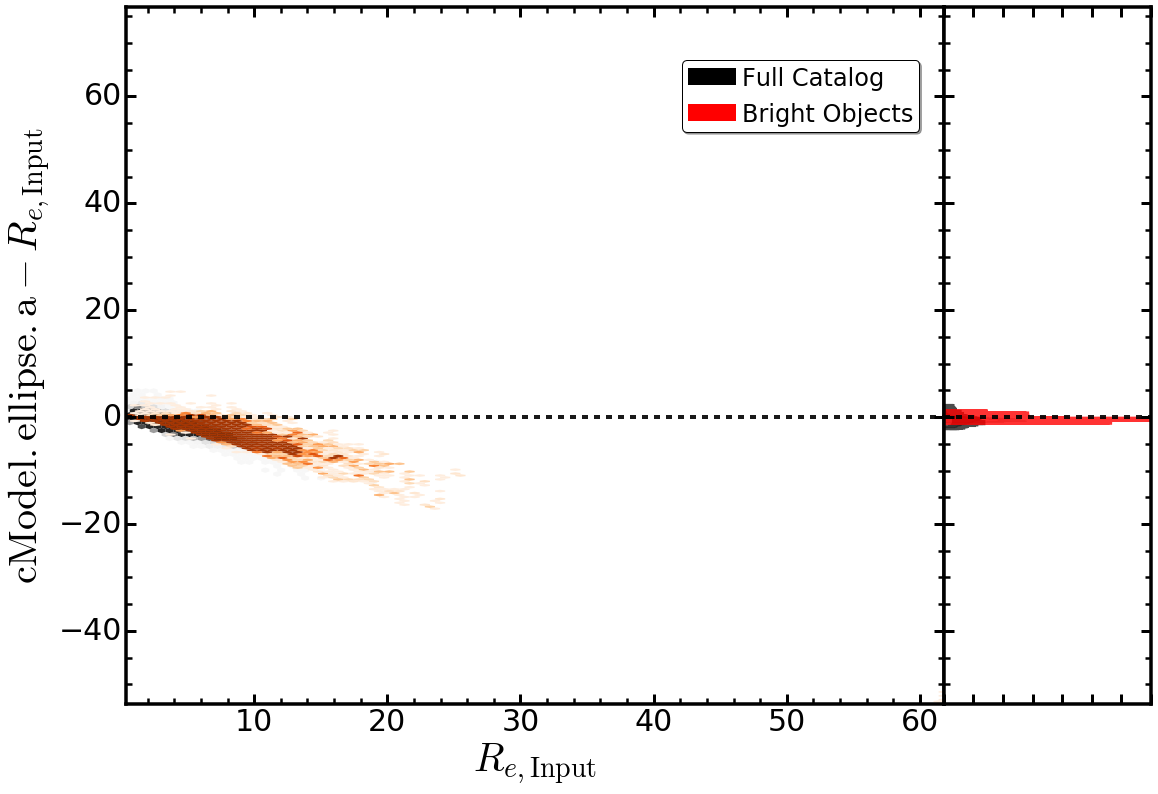

In [262]:
#del xx1, yy1, xx2, yy2

xx1 = photoI1['reff'] / (0.168 * photoI1['b_a'])
yy1 = photoI1['cmodel.initial.ellipse_a'] - photoI1['reff'] / (0.168 * photoI1['b_a'])

xx2 = photoI2['reff'] / (0.168 * photoI2['b_a'])
yy2 = photoI2['cmodel.initial.ellipse_a'] - photoI2['reff'] / (0.168 * photoI2['b_a'])

indexFaint1 = np.where(photoI1['blendedness.abs.flux'] >= 0.15)
indexFaint2 = np.where(photoI2['blendedness.abs.flux'] >= 0.15)

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(16, 11))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ----------------------------------------------------------------------------- #

ax1.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=5,
                 alpha=1.0, gridsize=[80, 80], label='Full Catalog',
                 marginals=False, vmin=30, vmax=200, facecolor='k', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap3, mincnt=1,
                 alpha=1.0, gridsize=[80, 80], label='Bright Objects',
                 marginals=False, vmin=3, vmax=25, facecolor='r', 
                 edgecolor='none')


ax1.set_xlabel('$R_{e, \mathrm{Input}}$', size=40)
ax1.set_ylabel('$\mathrm{cModel.ellipse.a} - R_{e, \mathrm{Input}}$', size=40)

#ax1.set_xlim(0.21, 1.02)
#ax1.set_ylim(-0.09, 0.69)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.68, 0.82), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# ----------------------------------------------------------------------------- #

# Histogram 
n, bins, patches=ax2.hist(yy1, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='k', alpha=0.30, normed=1)
n, bins, patches=ax2.hist(yy2, bins=120, range=[-1.0, 1.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='r', alpha=0.20, normed=1)


n, bins, patches=ax2.hist(yy1[indexFaint1], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='k', alpha=0.70, normed=1, linewidth=5.0)
n, bins, patches=ax2.hist(yy2[indexFaint2], bins=140, range=[-1.0, 1.0], 
                          orientation='horizontal', histtype='step', 
                          color='r', alpha=0.80, normed=1, linewidth=5.0)


ax2.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

ax2.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)

#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('y', length=6, width=2.5, which='minor')
ax2.tick_params('x', length=0, width=1.0, which='minor')

#ax2.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
#            alpha=0.8)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater


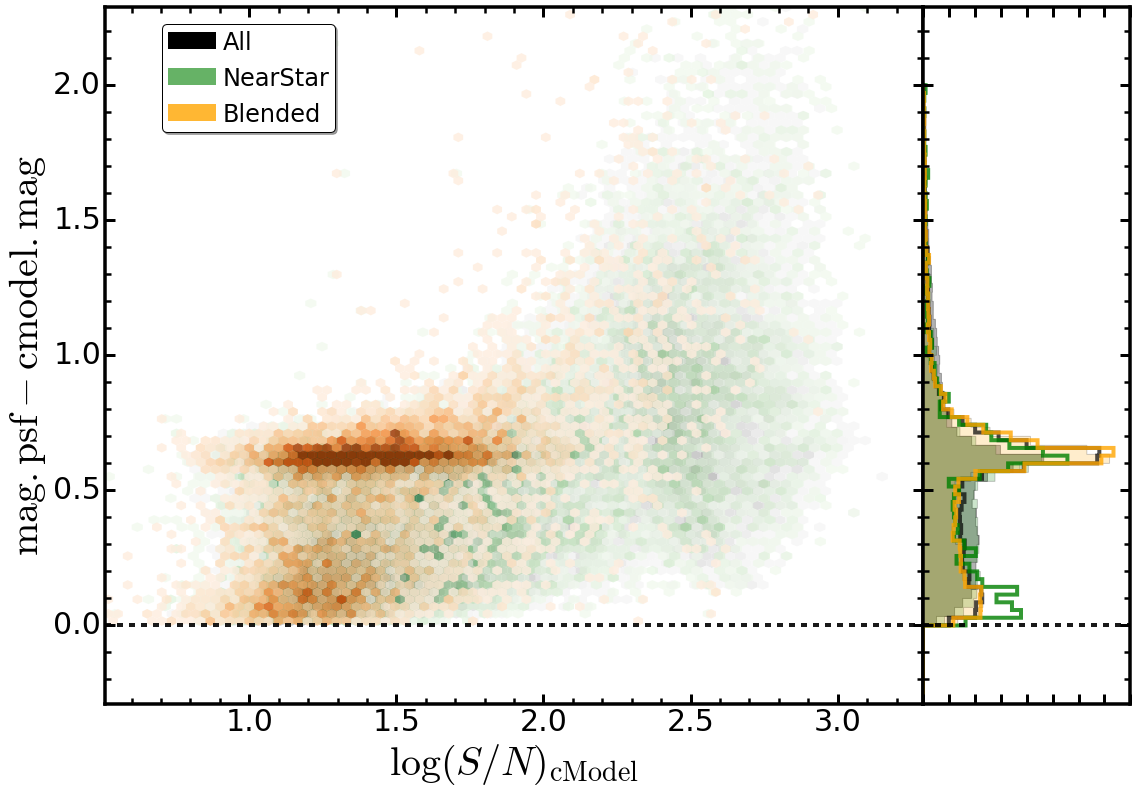

In [222]:
xx1 = np.log10(fakePhoto['cmodel.flux'] / fakePhoto['cmodel.flux.err'])
yy1 = (fakePhoto['cmodel.mag'] - fakePhoto['mag.psf']) * -1.0

xx2 = np.log10(fakeNearStar['cmodel.flux'] / fakeNearStar['cmodel.flux.err'])
yy2 = (fakeNearStar['cmodel.mag'] - fakeNearStar['mag.psf']) * -1.0

xx3 = np.log10(fakeBlended['cmodel.flux'] / fakeBlended['cmodel.flux.err'])
yy3 = (fakeBlended['cmodel.mag'] - fakeBlended['mag.psf']) * -1.0

indexFaint1 = np.where(fakePhoto['blendedness.abs.flux'] > 0.15)
indexFaint2 = np.where(fakeNearStar['blendedness.abs.flux'] > 0.15)
indexFaint3 = np.where(fakeBlended['blendedness.abs.flux'] > 0.15)

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(16, 11))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ----------------------------------------------------------------------------- #

ax1.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=5,
                 alpha=1.0, gridsize=[80, 80], label='All',
                 marginals=False, vmin=10, vmax=160, facecolor='k', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap2, mincnt=1,
                 alpha=0.6, gridsize=[80, 80], label='NearStar',
                 marginals=False, vmin=1, vmax=20, facecolor='g', 
                 edgecolor='none')

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=1,
                 alpha=0.8, gridsize=[80, 80], label='Blended',
                 marginals=False, vmin=1, vmax=20, facecolor='orange', 
                 edgecolor='none')


ax1.set_xlabel('$\log (S/N)_{\mathrm{cModel}}$', size=40)
ax1.set_ylabel('$\mathrm{mag.psf} - \mathrm{cmodel.mag}$', size=40)

ax1.set_xlim(0.51, 3.29)
ax1.set_ylim(-0.29, 2.29)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.07, 0.82), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# ----------------------------------------------------------------------------- #

# Histogram 
n, bins, patches=ax2.hist(yy1, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='k', alpha=0.30, normed=1)
n, bins, patches=ax2.hist(yy2, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='g', alpha=0.20, normed=1)
n, bins, patches=ax2.hist(yy3, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='orange', alpha=0.20, normed=1)


n, bins, patches=ax2.hist(yy1[indexFaint1], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='k', alpha=0.70, normed=1, linewidth=4.0)
n, bins, patches=ax2.hist(yy2[indexFaint2], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='g', alpha=0.80, normed=1, linewidth=4.0)
n, bins, patches=ax2.hist(yy3[indexFaint3], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='orange', alpha=0.80, normed=1, linewidth=4.0)


ax2.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

ax2.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)

#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('y', length=6, width=2.5, which='minor')
ax2.tick_params('x', length=0, width=1.0, which='minor')

#ax2.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
#            alpha=0.8)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

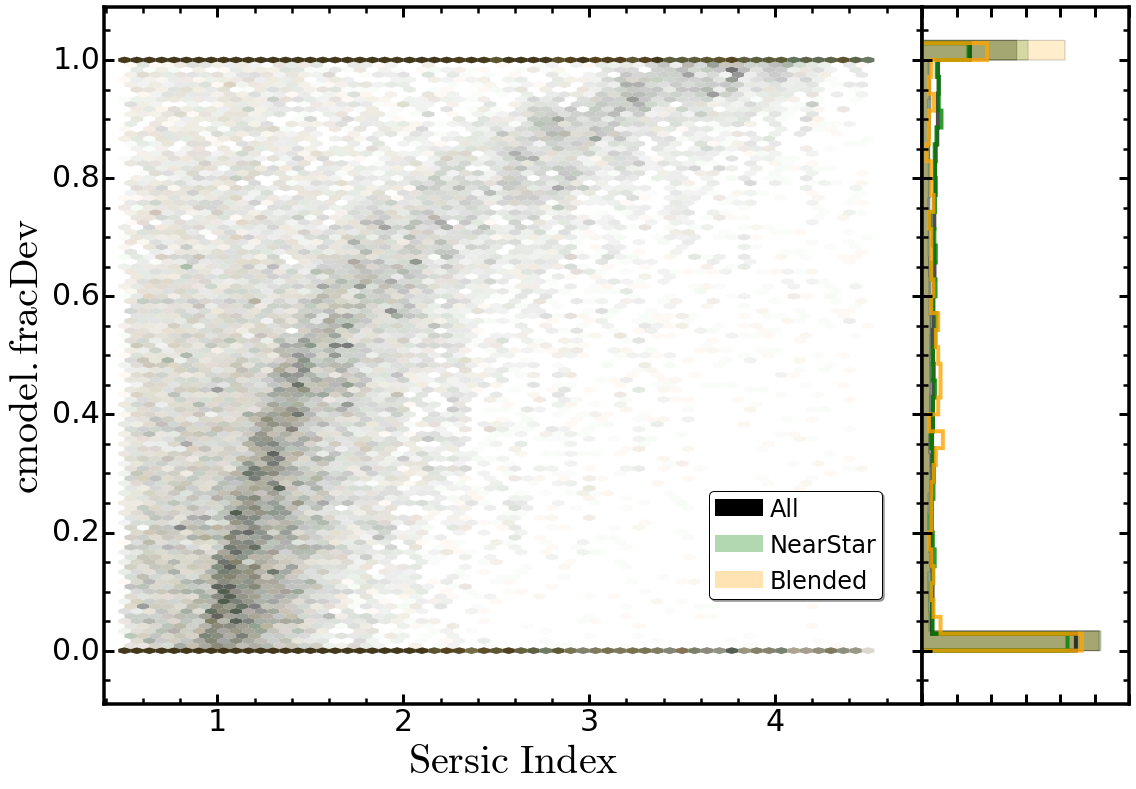

In [231]:
xx1 = fakePhoto['sersic_n']
yy1 = fakePhoto['cmodel.fracDev']

xx2 = fakeNearStar['sersic_n']
yy2 = fakeNearStar['cmodel.fracDev']

xx3 = fakeBlended['sersic_n']
yy3 = fakeBlended['cmodel.fracDev']

indexFaint1 = np.where(fakePhoto['cmodel.mag'] <= 21.5)
indexFaint2 = np.where(fakeNearStar['cmodel.mag'] <= 21.5)
indexFaint3 = np.where(fakeBlended['cmodel.mag'] <= 21.5)

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(16, 11))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ----------------------------------------------------------------------------- #

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=5,
                 alpha=1.0, gridsize=[60, 60], label='All',
                 marginals=False, vmin=4, vmax=40, facecolor='k', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap2, mincnt=1,
                 alpha=0.3, gridsize=[60, 60], label='NearStar',
                 marginals=False, vmin=1, vmax=20, facecolor='g', 
                 edgecolor='none')

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=1,
                 alpha=0.3, gridsize=[60, 60], label='Blended',
                 marginals=False, vmin=1, vmax=20, facecolor='orange', 
                 edgecolor='none')


ax1.set_xlabel('$\mathrm{Sersic\ Index}$', size=40)
ax1.set_ylabel('$\mathrm{cmodel.fracDev}$', size=40)

ax1.set_xlim(0.39, 4.79)
ax1.set_ylim(-0.09, 1.09)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.74, 0.15), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# ----------------------------------------------------------------------------- #

# Histogram 
n, bins, patches=ax2.hist(yy1, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='k', alpha=0.30, normed=1)
n, bins, patches=ax2.hist(yy2, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='g', alpha=0.20, normed=1)
n, bins, patches=ax2.hist(yy3, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='orange', alpha=0.20, normed=1)

n, bins, patches=ax2.hist(yy1[indexFaint1], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='k', alpha=0.70, normed=1, linewidth=4.0)
n, bins, patches=ax2.hist(yy2[indexFaint2], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='g', alpha=0.80, normed=1, linewidth=4.0)
n, bins, patches=ax2.hist(yy3[indexFaint3], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='orange', alpha=0.80, normed=1, linewidth=4.0)

ax2.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)

#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('y', length=6, width=2.5, which='minor')
ax2.tick_params('x', length=0, width=1.0, which='minor')

#ax2.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
#            alpha=0.8)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

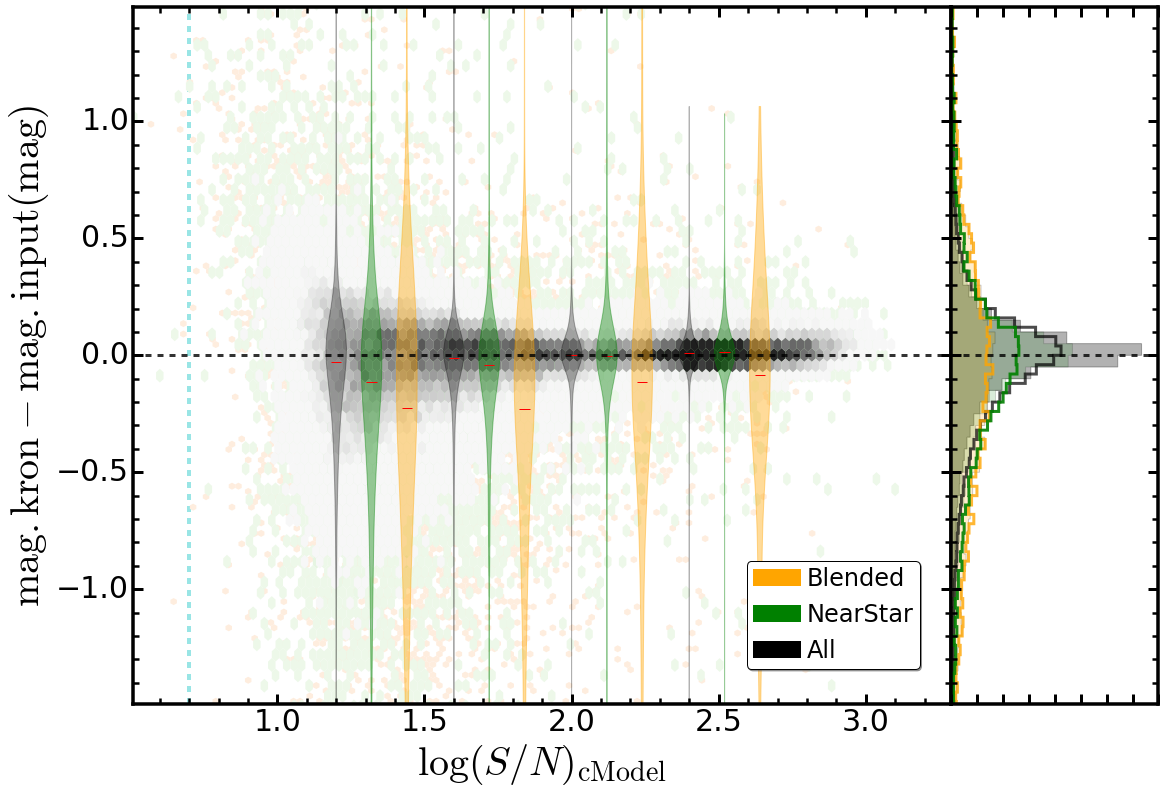

In [236]:
xx1, yy1 = np.log10(fakePhoto['cmodel.flux'] / fakePhoto['cmodel.flux.err']), (fakePhoto['mag.kron'] - fakePhoto['mag_i'])
xx2, yy2 = np.log10(fakeNearStar['cmodel.flux'] / fakeNearStar['cmodel.flux.err']), (fakeNearStar['mag.kron'] - fakeNearStar['mag_i'])
xx3, yy3 = np.log10(fakeBlended['cmodel.flux'] / fakeBlended['cmodel.flux.err']), (fakeBlended['mag.kron'] - fakeBlended['mag_i'])

indexFaint1 = np.where(fakePhoto['mag_i'] >= 23.0)
indexFaint2 = np.where(fakeNearStar['mag_i'] >= 23.0)
indexFaint3 = np.where(fakeBlended['mag_i'] >= 23.0)

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(16, 11))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ----------------------------------------------------------------------------- #

ax1.axvline(np.log10(5.0), linewidth=4.0, linestyle='--', color='c', 
            alpha=0.4, zorder=0)

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=1,
                 alpha=1.0, gridsize=[120, 200], label='Blended',
                 marginals=False, vmin=5, vmax=100, facecolor='orange', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap2, mincnt=1,
                 alpha=1.0, gridsize=[120, 200], label='NearStar',
                 marginals=False, vmin=5, vmax=60, facecolor='g', 
                 edgecolor='none')

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=10,
                 alpha=1.0, gridsize=[120, 200], label='All',
                 marginals=False, vmin=50, vmax=280, facecolor='k', 
                 edgecolor='none')

# ----------------------------------------------------------------------------- #


# ----------------------------------------------------------------------------- #
    
ax1.set_xlabel('$\log (S/N)_{\mathrm{cModel}}$', size=40)
ax1.set_ylabel('$\mathrm{mag.kron} - \mathrm{mag.input (mag)}$', size=40)

ax1.set_xlim(0.51, 3.29)
ax1.set_ylim(-1.49, 1.49)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.75, 0.05), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

ax1.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
            alpha=0.8)

# ----------------------------------------------------------------------------- #

# Histogram 
n, bins, patches=ax2.hist(yy1, bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='k', alpha=0.30, normed=1)
n, bins, patches=ax2.hist(yy3, bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='orange', alpha=0.20, normed=1)
n, bins, patches=ax2.hist(yy2, bins=80, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='g', alpha=0.15, normed=1)

n, bins, patches=ax2.hist(yy1[indexFaint1], bins=100, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='k', alpha=0.70, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy3[indexFaint3], bins=100, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='orange', alpha=0.80, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy2[indexFaint2], bins=100, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='g', alpha=0.90, normed=1, linewidth=3.0)

ax2.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)

#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('y', length=6, width=2.5, which='minor')
ax2.tick_params('x', length=0, width=1.0, which='minor')

ax2.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
            alpha=0.8)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())


# ----------------------------------------------------------------------------- #

xxU = xx1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyU = yy1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot1 = ax1.violinplot(yyV, positions=[1.2, 1.6, 2.0, 2.4],  
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot1['bodies']:
    pc.set_facecolor('k')
    pc.set_edgecolor('k')
    pc.set_alpha(0.3)
pm = vplot1['cmedians']
pm.set_linewidths=5.0               

xxU = xx2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyU = yy2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot2 = ax1.violinplot(yyV, positions=[1.32, 1.72, 2.12, 2.52], 
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot2['bodies']:
    pc.set_facecolor('g')
    pc.set_edgecolor('g')
    pc.set_alpha(0.4)
  
xxU = xx3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyU = yy3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot3 = ax1.violinplot(yyV, positions=[1.44, 1.84, 2.24, 2.64], 
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot3['bodies']:
    pc.set_facecolor('orange')
    pc.set_edgecolor('orange')
    pc.set_alpha(0.4)

# ----------------------------------------------------------------------------- #

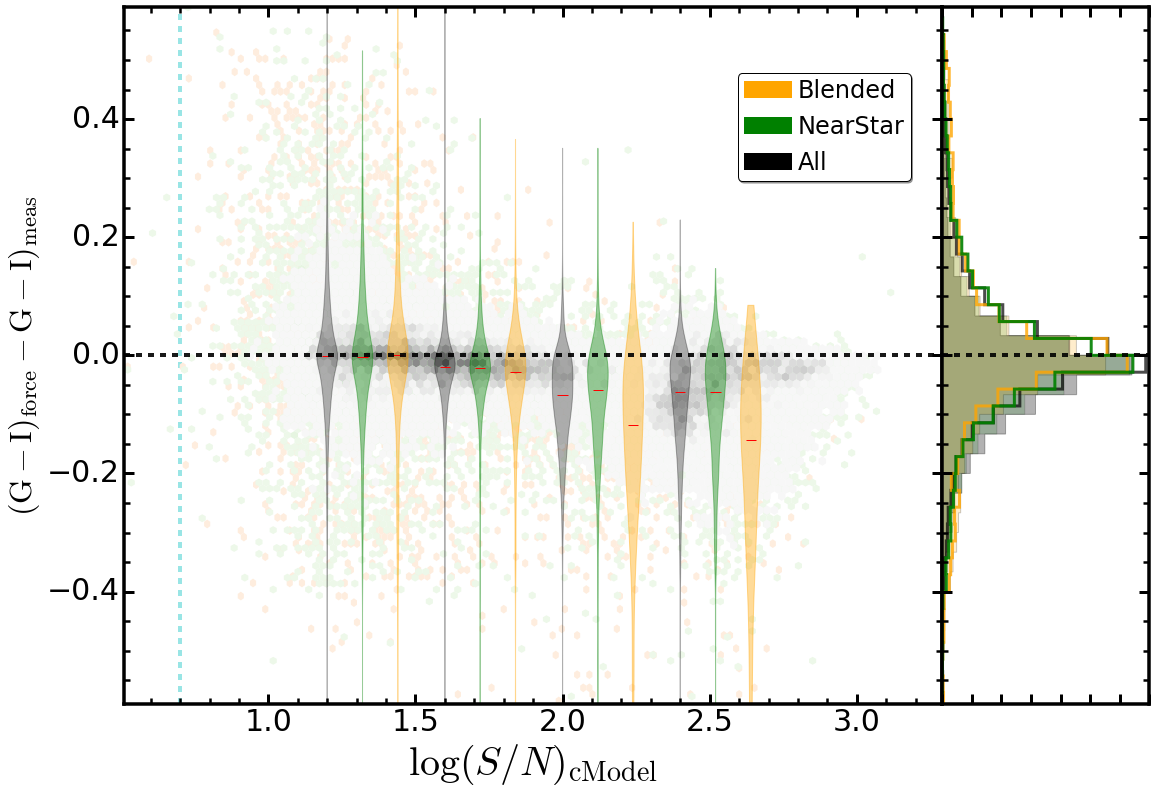

In [271]:
xx1 = np.log10(photoIG['cmodel.flux_1'] / photoIG['cmodel.flux.err_1'])
yy1 = (photoIG['force.cmodel.mag_2'] - 
       photoIG['force.cmodel.mag_1']) - (photoIG['cmodel.mag_2'] - photoIG['cmodel.mag_1'])

xx2 = np.log10(nearStarIG['cmodel.flux_1'] / nearStarIG['cmodel.flux.err_1'])
yy2 = (nearStarIG['force.cmodel.mag_2'] - 
       nearStarIG['force.cmodel.mag_1']) - (nearStarIG['cmodel.mag_2'] - nearStarIG['cmodel.mag_1'])

xx3 = np.log10(blendedIG['cmodel.flux_1'] / blendedIG['cmodel.flux.err_1'])
yy3 = (blendedIG['force.cmodel.mag_2'] - 
       blendedIG['force.cmodel.mag_1']) - (blendedIG['cmodel.mag_2'] - blendedIG['cmodel.mag_1'])

indexFaint1 = np.where(photoIG['mag_i_1'] >= 23.0)
indexFaint2 = np.where(nearStarIG['mag_i_1'] >= 23.0)
indexFaint3 = np.where(blendedIG['mag_i_1'] >= 23.0)

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(16, 11))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ----------------------------------------------------------------------------- #

ax1.axvline(np.log10(5.0), linewidth=4.0, linestyle='--', color='c', 
            alpha=0.4, zorder=0)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=1,
                 alpha=1.0, gridsize=[120, 120], label='Blended',
                 marginals=False, vmin=5, vmax=30, facecolor='orange', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap2, mincnt=1,
                 alpha=1.0, gridsize=[120, 120], label='NearStar',
                 marginals=False, vmin=5, vmax=30, facecolor='g', 
                 edgecolor='none')

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=10,
                 alpha=1.0, gridsize=[120, 120], label='All',
                 marginals=False, vmin=40, vmax=200, facecolor='k', 
                 edgecolor='none')

ax1.set_xlabel('$\log (S/N)_{\mathrm{cModel}}$', size=40)
ax1.set_ylabel('$(\mathrm{G}-\mathrm{I})_{\mathrm{force}} - \mathrm{G}-\mathrm{I})_{\mathrm{meas}}$', size=32)

ax1.set_xlim(0.51, 3.29)
ax1.set_ylim(-0.59, 0.59)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.75, 0.75), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# ----------------------------------------------------------------------------- #

# Histogram 
n, bins, patches=ax2.hist(yy1, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='k', alpha=0.30, normed=1)
n, bins, patches=ax2.hist(yy3, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='orange', alpha=0.20, normed=1)
n, bins, patches=ax2.hist(yy2, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='g', alpha=0.15, normed=1)

n, bins, patches=ax2.hist(yy1[indexFaint1], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='k', alpha=0.70, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy3[indexFaint3], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='orange', alpha=0.80, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy2[indexFaint2], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='g', alpha=0.90, normed=1, linewidth=3.0)

ax2.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

ax2.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)

#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('y', length=6, width=2.5, which='minor')
ax2.tick_params('x', length=0, width=1.0, which='minor')

#ax2.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
#            alpha=0.8)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

# ----------------------------------------------------------------------------- #

xxU = xx1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyU = yy1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot1 = ax1.violinplot(yyV, positions=[1.2, 1.6, 2.0, 2.4],  
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot1['bodies']:
    pc.set_facecolor('k')
    pc.set_edgecolor('k')
    pc.set_alpha(0.3)
pm = vplot1['cmedians']
pm.set_linewidths=5.0               

xxU = xx2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyU = yy2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot2 = ax1.violinplot(yyV, positions=[1.32, 1.72, 2.12, 2.52], 
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot2['bodies']:
    pc.set_facecolor('g')
    pc.set_edgecolor('g')
    pc.set_alpha(0.4)
  
xxU = xx3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyU = yy3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot3 = ax1.violinplot(yyV, positions=[1.44, 1.84, 2.24, 2.64], 
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot3['bodies']:
    pc.set_facecolor('orange')
    pc.set_edgecolor('orange')
    pc.set_alpha(0.4)

# ----------------------------------------------------------------------------- #

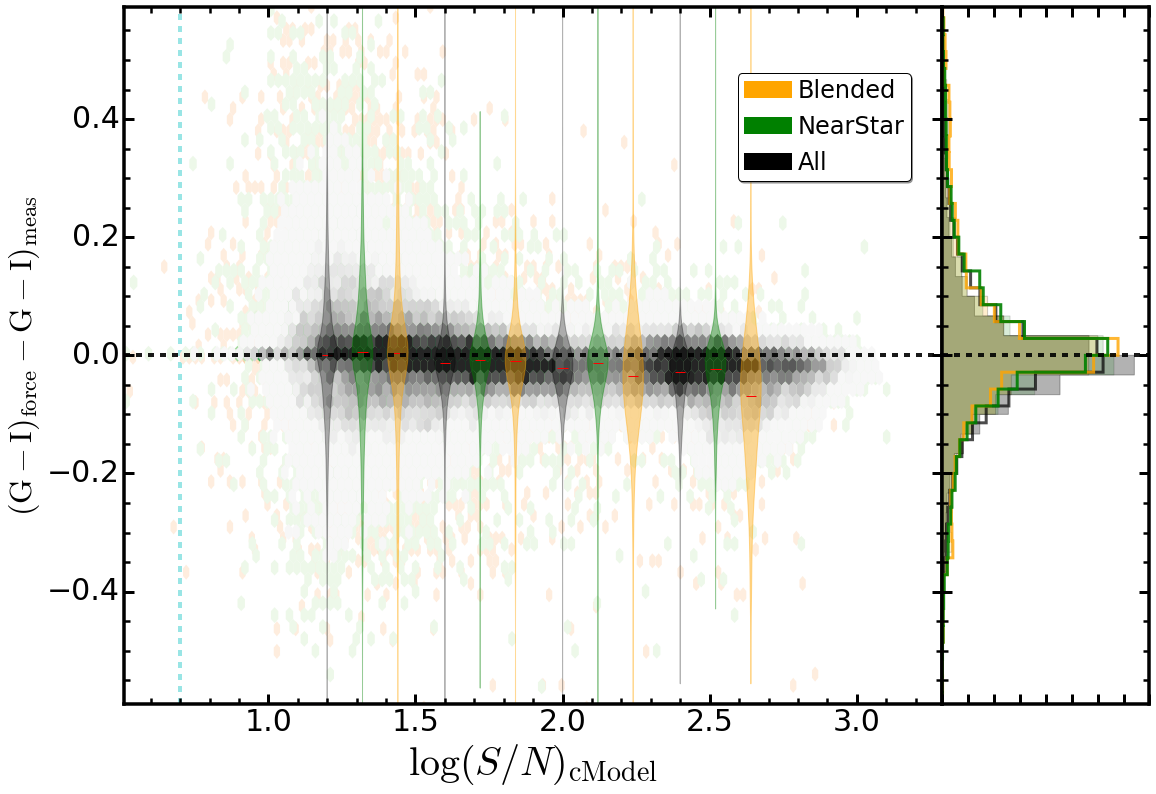

In [273]:
xx1 = np.log10(photoIR['cmodel.flux_1'] / photoIR['cmodel.flux.err_1'])
yy1 = photoIR['force.cmodel.mag_2'] - photoIR['cmodel.mag_2']

xx2 = np.log10(nearStarIR['cmodel.flux_1'] / nearStarIR['cmodel.flux.err_1'])
yy2 = nearStarIR['force.cmodel.mag_2'] - nearStarIR['cmodel.mag_2']

xx3 = np.log10(blendedIR['cmodel.flux_1'] / blendedIR['cmodel.flux.err_1'])
yy3 = blendedIR['force.cmodel.mag_2'] - blendedIR['cmodel.mag_2']

indexFaint1 = np.where(photoIR['mag_i_1'] >= 23.0)
indexFaint2 = np.where(nearStarIR['mag_i_1'] >= 23.0)
indexFaint3 = np.where(blendedIR['mag_i_1'] >= 23.0)

# ----------------------------------------------------------------------------- #

fig = plt.figure(figsize=(16, 11))
ax1 = plt.axes(recScat)
ax2 = plt.axes(recHist)

# ----------------------------------------------------------------------------- #

ax1.axvline(np.log10(5.0), linewidth=4.0, linestyle='--', color='c', 
            alpha=0.4, zorder=0)

ax1.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

hb3 = ax1.hexbin(xx3, yy3, cmap=cmap3, mincnt=1,
                 alpha=1.0, gridsize=[120, 120], label='Blended',
                 marginals=False, vmin=5, vmax=30, facecolor='orange', 
                 edgecolor='none')

hb2 = ax1.hexbin(xx2, yy2, cmap=cmap2, mincnt=1,
                 alpha=1.0, gridsize=[120, 120], label='NearStar',
                 marginals=False, vmin=5, vmax=30, facecolor='g', 
                 edgecolor='none')

hb1 = ax1.hexbin(xx1, yy1, cmap=cmap0, mincnt=10,
                 alpha=1.0, gridsize=[120, 120], label='All',
                 marginals=False, vmin=40, vmax=200, facecolor='k', 
                 edgecolor='none')

ax1.set_xlabel('$\log (S/N)_{\mathrm{cModel}}$', size=40)
ax1.set_ylabel('$(\mathrm{G}-\mathrm{I})_{\mathrm{force}} - \mathrm{G}-\mathrm{I})_{\mathrm{meas}}$', size=32)

ax1.set_xlim(0.51, 3.29)
ax1.set_ylim(-0.59, 0.59)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(30) 
    
ax1.legend(loc=(0.75, 0.75), shadow=True, fancybox=True, 
           numpoints=1, fontsize=24, scatterpoints=1, 
           markerscale=1.2, borderpad=0.25, handletextpad=0.25)

#ax1.text(0.10, 0.47, 'Size: ${\Lambda}_{\mathrm{redMapper}}$', 
#         verticalalignment='bottom', horizontalalignment='left',
#         fontsize=24.0, transform=ax1.transAxes)
    
ax1.spines['top'].set_linewidth(3.5)
ax1.spines['right'].set_linewidth(3.5)
ax1.spines['bottom'].set_linewidth(3.5)
ax1.spines['left'].set_linewidth(3.5)

#  Tick Length and Width
ax1.minorticks_on()
ax1.tick_params('both', length=10, width=3.0, which='major')
ax1.tick_params('both', length=6, width=2.5, which='minor')

# ----------------------------------------------------------------------------- #

# Histogram 
n, bins, patches=ax2.hist(yy1, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='k', alpha=0.30, normed=1)
n, bins, patches=ax2.hist(yy3, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='orange', alpha=0.20, normed=1)
n, bins, patches=ax2.hist(yy2, bins=120, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='stepfilled', 
                          color='g', alpha=0.15, normed=1)

n, bins, patches=ax2.hist(yy1[indexFaint1], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='k', alpha=0.70, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy3[indexFaint3], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='orange', alpha=0.80, normed=1, linewidth=3.0)
n, bins, patches=ax2.hist(yy2[indexFaint2], bins=140, range=[-2.0, 2.0], 
                          orientation='horizontal', histtype='step', 
                          color='g', alpha=0.90, normed=1, linewidth=3.0)

ax2.axhline(0.0, linewidth=4.0, linestyle='--', color='k', 
            alpha=0.9, zorder=1000)

ax2.set_ylim(ax1.get_ylim())

# Axes setup
#  Minor Ticks on 
ax2.minorticks_on()

#  Axes Thickness
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(3.5)

#  Tick Label Size 
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
    
#  Tick Length and Width
ax2.tick_params('both', length=10, width=3.0, which='major')
ax2.tick_params('y', length=6, width=2.5, which='minor')
ax2.tick_params('x', length=0, width=1.0, which='minor')

#ax2.axhline(0.0, linewidth=3.0, linestyle='--', color='k', 
#            alpha=0.8)

ax2.yaxis.set_major_formatter(NullFormatter())
ax2.xaxis.set_major_formatter(NullFormatter())

# ----------------------------------------------------------------------------- #

xxU = xx1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyU = yy1[(np.isfinite(yy1)) & (np.isfinite(xx1))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot1 = ax1.violinplot(yyV, positions=[1.2, 1.6, 2.0, 2.4],  
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot1['bodies']:
    pc.set_facecolor('k')
    pc.set_edgecolor('k')
    pc.set_alpha(0.3)
pm = vplot1['cmedians']
pm.set_linewidths=5.0               

xxU = xx2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyU = yy2[(np.isfinite(yy2)) & (np.isfinite(xx2))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot2 = ax1.violinplot(yyV, positions=[1.32, 1.72, 2.12, 2.52], 
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot2['bodies']:
    pc.set_facecolor('g')
    pc.set_edgecolor('g')
    pc.set_alpha(0.4)
  
xxU = xx3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyU = yy3[(np.isfinite(yy3)) & (np.isfinite(xx3))]
yyV = [np.asarray(yyU[(xxU >= 1.2) & (xxU < 1.6)]),
       np.asarray(yyU[(xxU >= 1.6) & (xxU < 2.0)]),
       np.asarray(yyU[(xxU >= 2.0) & (xxU < 2.4)]), 
       np.asarray(yyU[(xxU >= 2.4) & (xxU < 2.8)])]
vplot3 = ax1.violinplot(yyV, positions=[1.44, 1.84, 2.24, 2.64], 
                        vert=True, widths=0.07, showmeans=False, showmedians=True,
                        points=250, bw_method='scott', showextrema=False)
for pc in vplot3['bodies']:
    pc.set_facecolor('orange')
    pc.set_edgecolor('orange')
    pc.set_alpha(0.4)

# ----------------------------------------------------------------------------- #